In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from scipy import stats
from scipy.stats import chi2_contingency
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, roc_curve, auc, confusion_matrix, classification_report)
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

**INPUT DAN PREPROCESSING DATA**

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

file_name = next(iter(uploaded))

df = pd.read_excel(file_name)

print("File successfully uploaded and read:")
print(df.head())

Saving BlaBla.xlsx to BlaBla (4).xlsx
File successfully uploaded and read:
   A UMUR_TAHUN  B  C  D  E  F  G  H  I  J  K  L  M  N
0  1         17  0  1  0  0  0  0  0  1  0  0  0  1  0
1  5         70  0  0  0  0  0  0  0  1  1  1  0  1  1
2  3         39  0  0  0  0  0  1  0  0  0  0  0  1  0
3  5         63  0  0  0  0  0  0  0  0  1  0  0  1  0
4  3         40  0  0  0  0  0  1  0  0  0  1  0  1  0


   A UMUR_TAHUN  B  C  D  E  F  G  H  I  J  K  L  M  N
0  1         17  0  1  0  0  0  0  0  1  0  0  0  1  0
1  5         70  0  0  0  0  0  0  0  1  1  1  0  1  1
2  3         39  0  0  0  0  0  1  0  0  0  0  0  1  0
3  5         63  0  0  0  0  0  0  0  0  1  0  0  1  0
4  3         40  0  0  0  0  0  1  0  0  0  1  0  1  0
Kolom input yang ditemukan: ['A', 'UMUR_TAHUN', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
Kolom output: N

Shape X (fitur): (2308, 14)
Shape y (target): (2308,)

==== Check Missing Values ====
A             0
UMUR_TAHUN    0
B             0
C             0
D             0
E             0
F             0
G             0
H             0
I             0
J             0
K             0
L             0
M             0
N             0
dtype: int64

==== Check Outlier ====
Deteksi Outlier per Kolom:
------------------------------------------------------------
A:
  - Outlier (IQR): 0 (0.0%)
  - Outlier (Z-score): 0 (0.0%)
  - IQR bounds: [-2.00, 6.00]


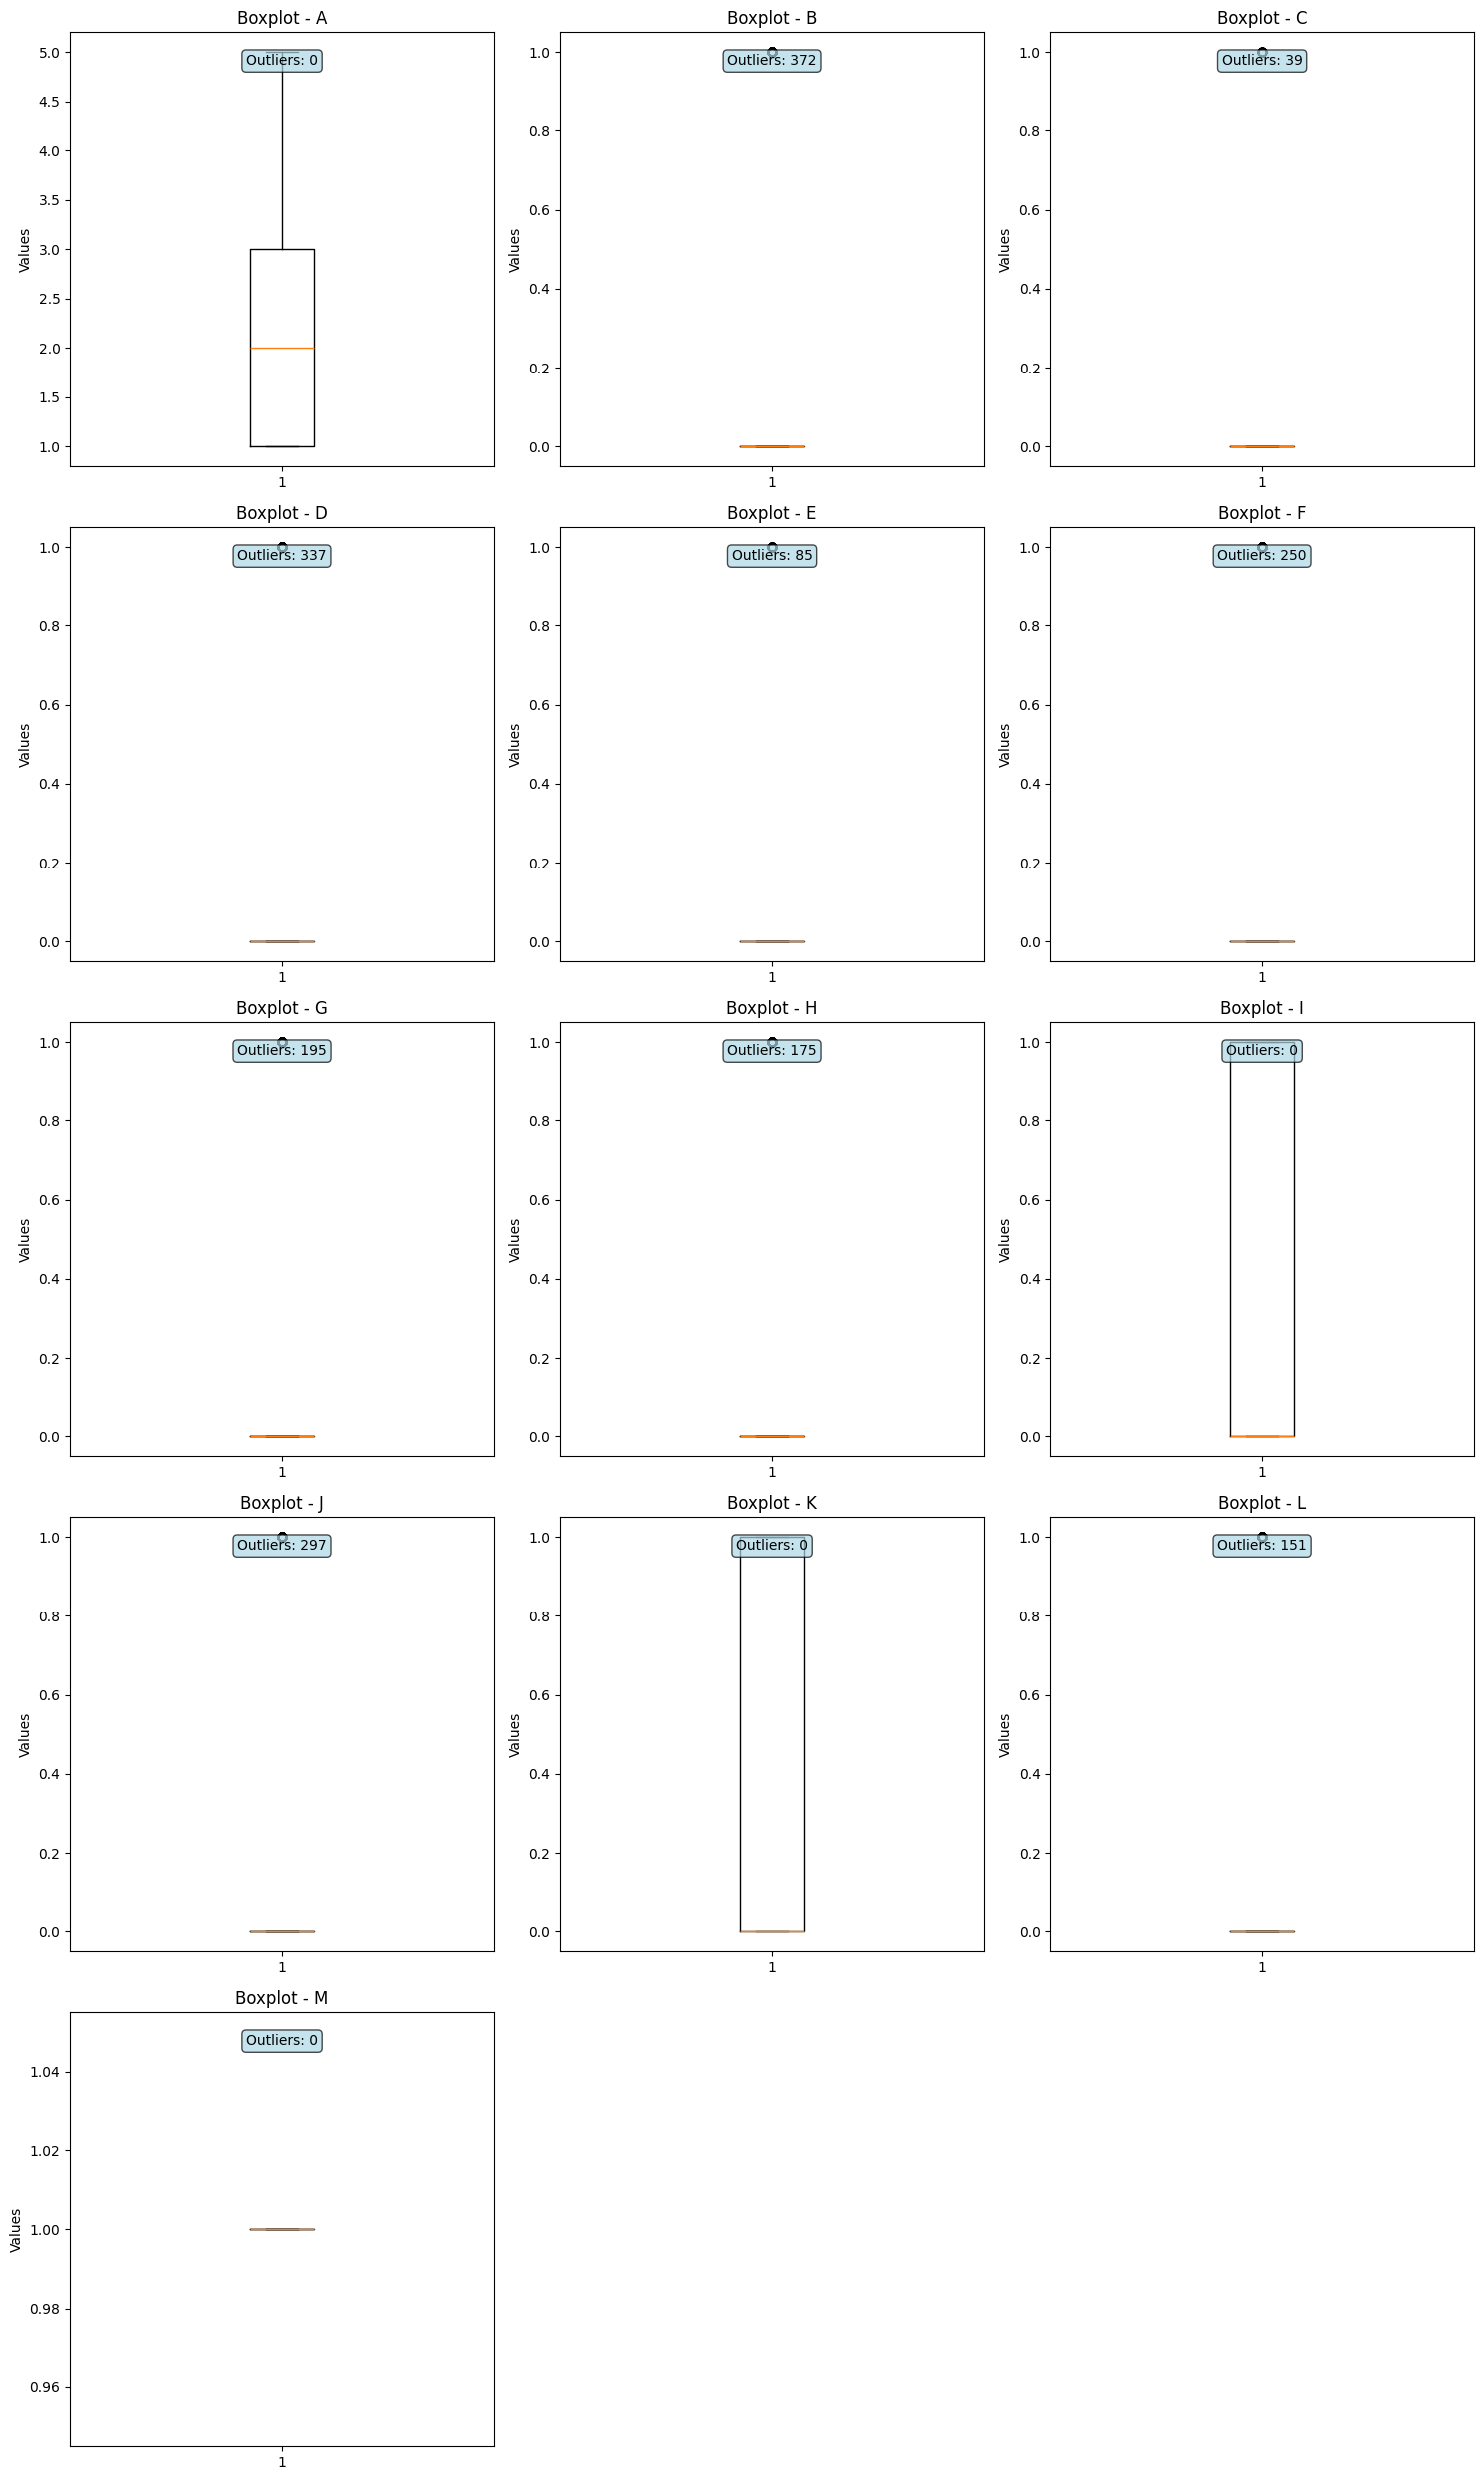


==== Handling Outlier ====
Menggunakan Percentile Capping (5%-95%):
A: Cap pada [1.00, 5.00]
Skipping capping for non-numeric column: UMUR_TAHUN
B: Cap pada [0.00, 1.00]
C: Cap pada [0.00, 0.00]
D: Cap pada [0.00, 1.00]
E: Cap pada [0.00, 0.00]
F: Cap pada [0.00, 1.00]
G: Cap pada [0.00, 1.00]
H: Cap pada [0.00, 1.00]
I: Cap pada [0.00, 1.00]
J: Cap pada [0.00, 1.00]
K: Cap pada [0.00, 1.00]
L: Cap pada [0.00, 1.00]
M: Cap pada [1.00, 1.00]

Shape final: X(2308, 14), y(2308,)
Outlier handling selesai!

==== Encoding ====
Encoding kolom UMUR_TAHUN...
Distribusi umur sebelum encoding:
Min: 0.0
Max: 80.0
Mean: 28.9

Distribusi setelah encoding:
0 (Error/Unknown): 1 orang
1 (≤ 20 tahun): 785 orang
2 (21-30 tahun): 566 orang
3 (31-40 tahun): 451 orang
4 (41-50 tahun): 294 orang
5 (> 50 tahun): 211 orang
Encoding UMUR_TAHUN selesai!

Shape setelah encoding: X(2308, 14), y(2308,)
Preprocessing selesai!


In [ ]:
# 1. Input Dataset
data = pd.read_excel('BlaBla.xlsx')
print(data.head())

# a. variabel input
input_columns = [col for col in data.columns if col in ['A', 'UMUR_TAHUN', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']]
# b. variabel output
output_column = 'N'

print(f"Kolom input yang ditemukan: {input_columns}")
print(f"Kolom output: {output_column}")

# Pisahkan fitur (X) dan target (y)
X = data[input_columns]
y = data[output_column]

print(f"\nShape X (fitur): {X.shape}")
print(f"Shape y (target): {y.shape}")

# 2. Preprocessing Data
print("\n==== Check Missing Values ====")
print(data.isnull().sum())

print("\n==== Check Outlier ====")

def detect_outliers_iqr(df, column):
    """Deteksi outlier menggunakan metode IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.index, lower_bound, upper_bound, len(outliers)

def detect_outliers_zscore(df, column, threshold=3):
    """Deteksi outlier menggunakan Z-score"""
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers.index, len(outliers)

# Check outlier untuk setiap kolom
outlier_summary = {}

print("Deteksi Outlier per Kolom:")
print("-" * 60)

for col in input_columns:
    if X[col].dtype in ['int64', 'float64']:  # Hanya untuk kolom numerik
        # Metode IQR
        outlier_idx_iqr, lower, upper, count_iqr = detect_outliers_iqr(X, col)

        # Metode Z-score
        outlier_idx_zscore, count_zscore = detect_outliers_zscore(X, col)

        # Simpan informasi
        outlier_summary[col] = {
            'iqr_count': count_iqr,
            'zscore_count': count_zscore,
            'iqr_bounds': (lower, upper),
            'outlier_indices_iqr': list(outlier_idx_iqr),
            'outlier_indices_zscore': list(outlier_idx_zscore)
        }

        print(f"{col}:")
        print(f"  - Outlier (IQR): {count_iqr} ({count_iqr/len(X)*100:.1f}%)")
        print(f"  - Outlier (Z-score): {count_zscore} ({count_zscore/len(X)*100:.1f}%)")
        print(f"  - IQR bounds: [{lower:.2f}, {upper:.2f}]")
        print(f"  - Min: {X[col].min():.2f}, Max: {X[col].max():.2f}")
        print()
    else:
        print(f"Skipping outlier detection for non-numeric column: {col}")


# Visualisasi outlier
print("==== Visualisasi Outlier ====")
# Filter input_columns to include only numeric columns for plotting
numeric_input_columns = [col for col in input_columns if X[col].dtype in ['int64', 'float64']]

if numeric_input_columns:
    n_cols = 3
    n_rows = (len(numeric_input_columns) + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))

    for i, col in enumerate(numeric_input_columns):
        plt.subplot(n_rows, n_cols, i + 1)

        # Boxplot
        plt.boxplot(X[col])
        plt.title(f'Boxplot - {col}')
        plt.ylabel('Values')

        # Tambahkan informasi outlier
        if col in outlier_summary:
            outlier_count = outlier_summary[col]['iqr_count']
            plt.text(0.5, 0.95, f'Outliers: {outlier_count}',
                    transform=plt.gca().transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns found for outlier visualization.")


print("\n==== Handling Outlier ====")

# Metode 1: Capping/Clipping (Paling Simpel)
def handle_outliers_simple(X):
    """Handling outlier dengan capping menggunakan percentile"""
    X_processed = X.copy()

    for col in X.columns:
        # Only apply capping to numeric columns
        if X_processed[col].dtype in ['int64', 'float64']:
            # Cap pada percentile 5% dan 95%
            lower = X_processed[col].quantile(0.05)
            upper = X_processed[col].quantile(0.95)

            X_processed[col] = X_processed[col].clip(lower=lower, upper=upper)

            print(f"{col}: Cap pada [{lower:.2f}, {upper:.2f}]")
        else:
             print(f"Skipping capping for non-numeric column: {col}")


    return X_processed

# Implementasi
print("Menggunakan Percentile Capping (5%-95%):")
X_processed = handle_outliers_simple(X)
y_processed = y.copy()

print(f"\nShape final: X{X_processed.shape}, y{y_processed.shape}")
print("Outlier handling selesai!")

print("\n==== Encoding ====")

# b. Encoding Umur
def encode_umur(data):
    """
    Encoding kolom UMUR_TAHUN menjadi kategori:
    1 = ≤ 20
    2 = ≥ 21 and ≤ 30
    3 = ≥ 31 and ≤ 40
    4 = ≥ 41 and ≤ 50
    5 = > 50
    """
    data_encoded = data.copy()

    if 'UMUR_TAHUN' in data_encoded.columns:
        print("Encoding kolom UMUR_TAHUN...")


        data_encoded['UMUR_TAHUN'] = pd.to_numeric(data_encoded['UMUR_TAHUN'], errors='coerce')


        print(f"Distribusi umur sebelum encoding:")

        numeric_umur = data_encoded['UMUR_TAHUN'].dropna()
        if not numeric_umur.empty:
            print(f"Min: {numeric_umur.min()}")
            print(f"Max: {numeric_umur.max()}")
            print(f"Mean: {numeric_umur.mean():.1f}")
        else:
            print("No valid numeric values found in 'UMUR_TAHUN' for min/max/mean calculation.")

        # Buat kondisi encoding
        conditions = [
            (data_encoded['UMUR_TAHUN'] <= 20),
            (data_encoded['UMUR_TAHUN'] >= 21) & (data_encoded['UMUR_TAHUN'] <= 30),
            (data_encoded['UMUR_TAHUN'] >= 31) & (data_encoded['UMUR_TAHUN'] <= 40),
            (data_encoded['UMUR_TAHUN'] >= 41) & (data_encoded['UMUR_TAHUN'] <= 50),
            (data_encoded['UMUR_TAHUN'] > 50)
        ]

        choices = [1, 2, 3, 4, 5]

        data_encoded['UMUR_TAHUN'] = np.select(conditions, choices, default=0)

        # Cek hasil encoding
        print(f"\nDistribusi setelah encoding:")
        encoding_counts = data_encoded['UMUR_TAHUN'].value_counts().sort_index()
        for code, count in encoding_counts.items():
            if code == 1:
                print(f"1 (≤ 20 tahun): {count} orang")
            elif code == 2:
                print(f"2 (21-30 tahun): {count} orang")
            elif code == 3:
                print(f"3 (31-40 tahun): {count} orang")
            elif code == 4:
                print(f"4 (41-50 tahun): {count} orang")
            elif code == 5:
                print(f"5 (> 50 tahun): {count} orang")
            elif code == 0:
                print(f"0 (Error/Unknown): {count} orang") # Includes NaN from coercion
        print("Encoding UMUR_TAHUN selesai!")
    else:
        print("Kolom 'UMUR_TAHUN' tidak ditemukan dalam dataset!")
    return data_encoded

# Implementasi encoding

X_final = encode_umur(X_processed)
y_final = y_processed.copy()

print(f"\nShape setelah encoding: X{X_final.shape}, y{y_final.shape}")
print("Preprocessing selesai!")

# SKENARIO 1

**IMBALANCED DATA (OVERSAMPLING)**


==== Check Imbalanced Data ====
Distribusi kelas sebelum oversampling:
N
0    1629
1     679
Name: count, dtype: int64

Persentase distribusi:
Kelas 0: 1629 sampel (70.6%)
Kelas 1: 679 sampel (29.4%)

Imbalance ratio: 2.40
Dataset terdeteksi IMBALANCED!

==== Oversampling Methods ====
Menerapkan berbagai metode oversampling...

--- SMOTE ---
Shape sebelum: (2308, 14)
Shape sesudah: (3258, 14)
Distribusi kelas setelah oversampling:
  Kelas 0: 1629 sampel (50.0%)
  Kelas 1: 1629 sampel (50.0%)

--- Random Oversampling ---
Shape sebelum: (2308, 14)
Shape sesudah: (3258, 14)
Distribusi kelas setelah oversampling:
  Kelas 0: 1629 sampel (50.0%)
  Kelas 1: 1629 sampel (50.0%)

--- ADASYN ---
Shape sebelum: (2308, 14)
Shape sesudah: (3232, 14)
Distribusi kelas setelah oversampling:
  Kelas 0: 1629 sampel (50.4%)
  Kelas 1: 1603 sampel (49.6%)

--- Borderline SMOTE ---
Shape sebelum: (2308, 14)
Shape sesudah: (3258, 14)
Distribusi kelas setelah oversampling:
  Kelas 0: 1629 sampel (50.0%)
  K

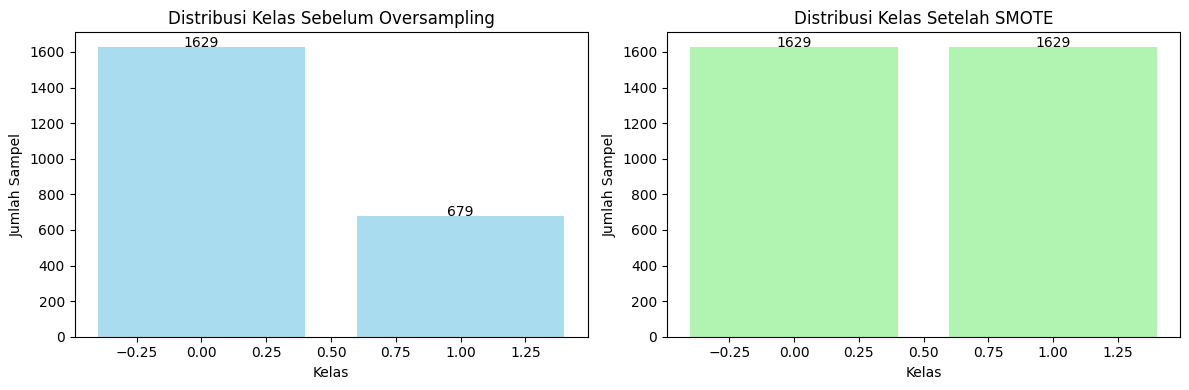


🎯 Data siap untuk modeling:
Shape final: X(3258, 14), y(3258,)
Preprocessing dan handling imbalanced data selesai!


In [ ]:
# ===============================
# IMBALANCED DATA HANDLING
# ===============================

print("\n==== Check Imbalanced Data ====")

# Cek distribusi kelas target
print("Distribusi kelas sebelum oversampling:")
class_distribution = y_final.value_counts().sort_index()
print(class_distribution)

# Hitung persentase
print("\nPersentase distribusi:")
for class_val, count in class_distribution.items():
    percentage = (count / len(y_final)) * 100
    print(f"Kelas {class_val}: {count} sampel ({percentage:.1f}%)")

# Cek apakah data imbalanced (jika ada kelas dengan < 10% dari total)
min_percentage = (class_distribution.min() / len(y_final)) * 100
max_percentage = (class_distribution.max() / len(y_final)) * 100
imbalance_ratio = max_percentage / min_percentage

print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("Dataset terdeteksi IMBALANCED!")
    apply_oversampling = True
else:
    print("Dataset relatif balanced")
    apply_oversampling = False


if apply_oversampling:
    print("\n==== Oversampling Methods ====")

    # Definisikan beberapa metode oversampling
    oversamplers = {
        'SMOTE': SMOTE(random_state=42),
        'Random Oversampling': RandomOverSampler(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'Borderline SMOTE': BorderlineSMOTE(random_state=42)
    }

    # Dictionary untuk menyimpan hasil
    oversampled_results = {}

    print("Menerapkan berbagai metode oversampling...\n")

    for method_name, oversampler in oversamplers.items():
        try:
            # Terapkan oversampling
            X_resampled, y_resampled = oversampler.fit_resample(X_final, y_final)

            # Simpan hasil
            oversampled_results[method_name] = {
                'X': X_resampled,
                'y': y_resampled,
                'shape': X_resampled.shape
            }

            # Tampilkan hasil
            print(f"--- {method_name} ---")
            print(f"Shape sebelum: {X_final.shape}")
            print(f"Shape sesudah: {X_resampled.shape}")

            # Distribusi kelas setelah oversampling
            new_distribution = Counter(y_resampled)
            print("Distribusi kelas setelah oversampling:")
            for class_val, count in sorted(new_distribution.items()):
                percentage = (count / len(y_resampled)) * 100
                print(f"  Kelas {class_val}: {count} sampel ({percentage:.1f}%)")
            print()

        except Exception as e:
            print(f"❌ Error pada {method_name}: {str(e)}")
            print()

    # Pilih metode terbaik (default: SMOTE)
    if 'SMOTE' in oversampled_results:
        recommended_method = 'SMOTE'
    elif oversampled_results:
        recommended_method = list(oversampled_results.keys())[0]
    else:
        recommended_method = None

    if recommended_method:
        print(f"Direkomendasikan menggunakan metode: {recommended_method}")
        X_balanced = oversampled_results[recommended_method]['X']
        y_balanced = oversampled_results[recommended_method]['y']

        print(f"Data final setelah oversampling:")
        print(f"Shape: {X_balanced.shape}")
        print(f"Distribusi kelas: {Counter(y_balanced)}")

        # Visualisasi perbandingan
        print("\n==== Visualisasi Perbandingan ====")

        plt.figure(figsize=(12, 4))

        # Plot sebelum oversampling
        plt.subplot(1, 2, 1)
        class_counts_before = y_final.value_counts().sort_index()
        plt.bar(class_counts_before.index, class_counts_before.values, alpha=0.7, color='skyblue')
        plt.title('Distribusi Kelas Sebelum Oversampling')
        plt.xlabel('Kelas')
        plt.ylabel('Jumlah Sampel')
        for i, v in enumerate(class_counts_before.values):
            plt.text(class_counts_before.index[i], v + 0.5, str(v), ha='center')

        # Plot setelah oversampling
        plt.subplot(1, 2, 2)
        class_counts_after = pd.Series(Counter(y_balanced)).sort_index()
        plt.bar(class_counts_after.index, class_counts_after.values, alpha=0.7, color='lightgreen')
        plt.title(f'Distribusi Kelas Setelah {recommended_method}')
        plt.xlabel('Kelas')
        plt.ylabel('Jumlah Sampel')
        for i, v in enumerate(class_counts_after.values):
            plt.text(class_counts_after.index[i], v + 0.5, str(v), ha='center')

        plt.tight_layout()
        plt.show()

    else:
        print("❌ Tidak ada metode oversampling yang berhasil diterapkan")
        X_balanced = X_final.copy()
        y_balanced = y_final.copy()

else:
    print("Dataset sudah balanced, tidak perlu oversampling")
    X_balanced = X_final.copy()
    y_balanced = y_final.copy()

print(f"\n🎯 Data siap untuk modeling:")
print(f"Shape final: X{X_balanced.shape}, y{y_balanced.shape}")
print("Preprocessing dan handling imbalanced data selesai!")

# SKENARIO 1

KLASIFIKASI DENGAN OVERSAMPLING (IMBALANCED DATA)


KLASIFIKASI - MODEL PADA DATA OVERSAMPLING (Split 80:20)

[1] PEMBAGIAN DATA
Training set: (2606, 14)
Test set: (652, 14)


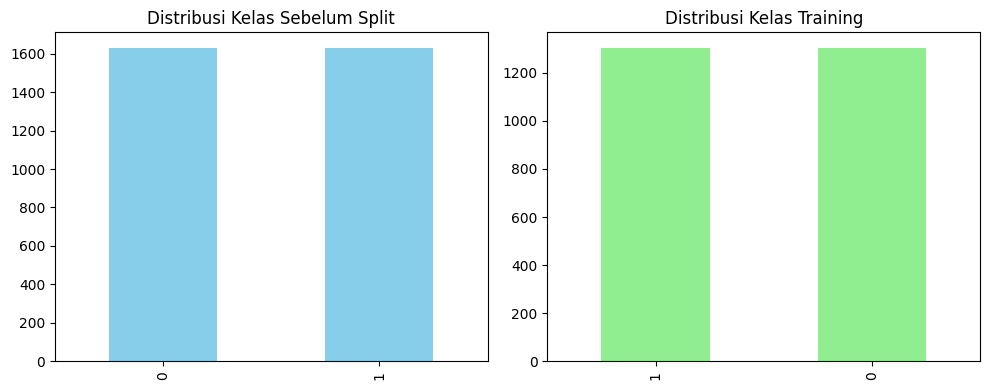


[2] INISIALISASI MODEL

[3] PELATIHAN MODEL

=== Decision Tree ===
Parameter: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


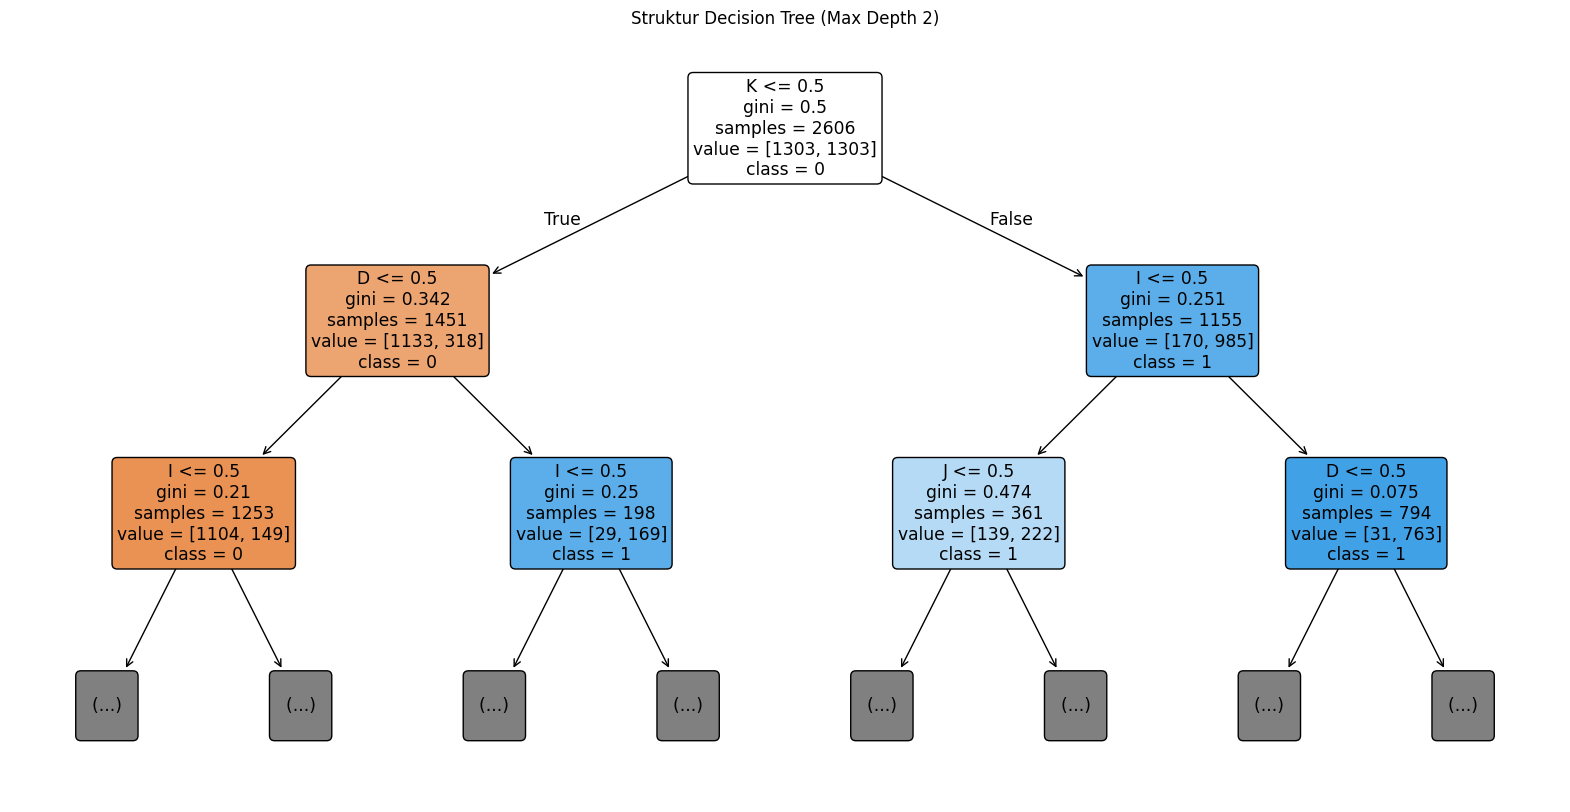

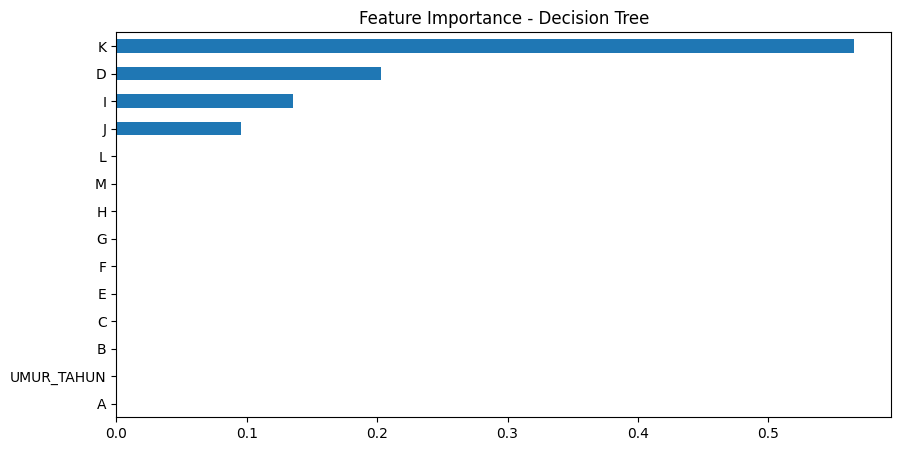


Waktu training: 0.01 detik

=== Random Forest ===
Parameter: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


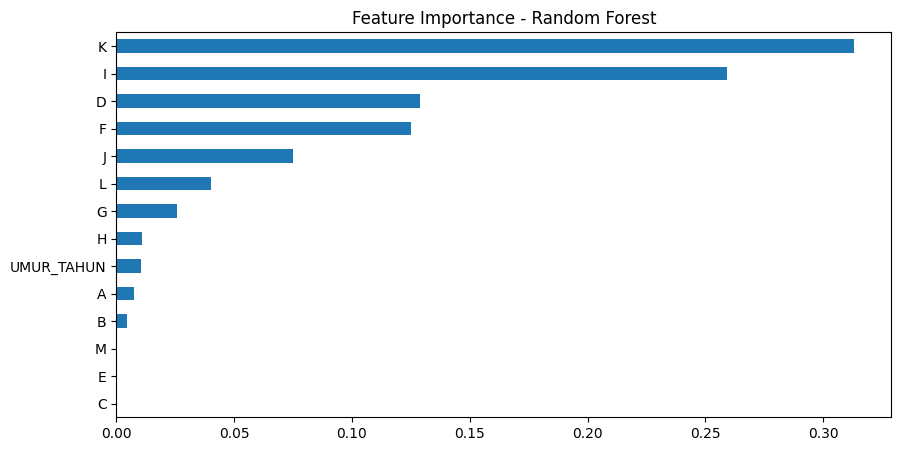


Waktu training: 0.20 detik

=== SVM ===
Parameter: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Waktu training: 0.20 detik

=== XGBoost ===
Parameter: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'm

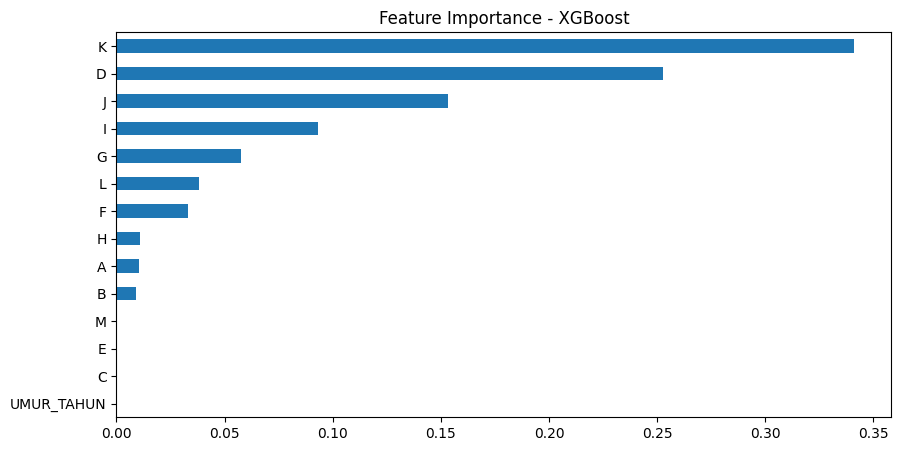


Waktu training: 0.12 detik

=== LightGBM ===
Parameter: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}


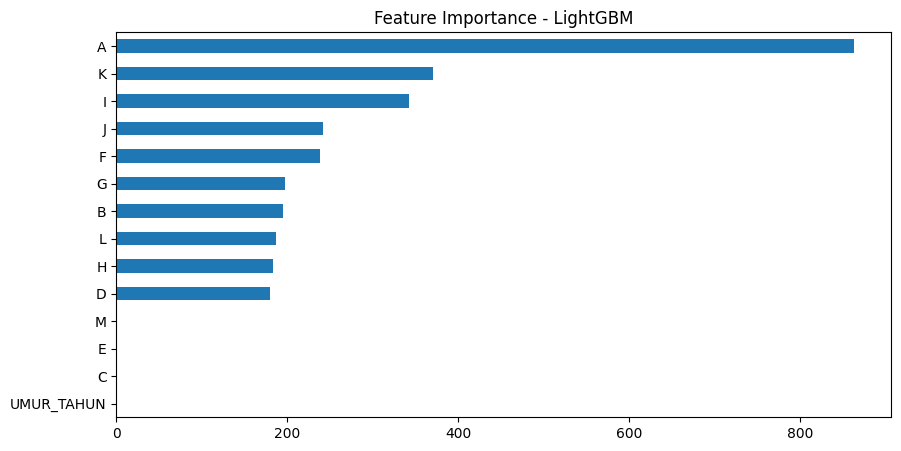


Waktu training: 0.11 detik


In [ ]:
# ============================================================
# SKENARIO 1: KLASIFIKASI DENGAN OVERSAMPLING
# ============================================================
print("\n" + "="*80)
print("KLASIFIKASI - MODEL PADA DATA OVERSAMPLING (Split 80:20)")
print("="*80)

# 1. Pembagian Data
print("\n[1] PEMBAGIAN DATA")
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"Training set: {X_train_over.shape}")
print(f"Test set: {X_test_over.shape}")

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pd.Series(Counter(y_balanced)).plot(kind='bar', color='skyblue')
plt.title('Distribusi Kelas Sebelum Split')
plt.subplot(1, 2, 2)
pd.Series(Counter(y_train_over)).plot(kind='bar', color='lightgreen')
plt.title('Distribusi Kelas Training')
plt.tight_layout()
plt.show()

# 2. Inisialisasi Model
print("\n[2] INISIALISASI MODEL")
models = {
    'Decision Tree': DecisionTreeClassifier(
        max_depth=3,  # Dikurangi untuk visualisasi lebih jelas
        min_samples_split=10,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ),
    'SVM': SVC(
        kernel='linear',
        C=1.0,
        random_state=42,
        probability=True
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        random_state=42,
        verbose=-1
    )
}

# 3. Pelatihan Model
print("\n[3] PELATIHAN MODEL")
trained_models_over = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    print("Parameter:", {k: v for k, v in model.get_params().items()
                       if not k.startswith('base_estimator__')})

    # Training
    start_time = time.time()
    model.fit(X_train_over, y_train_over)
    train_time = time.time() - start_time

    # Simpan model yang sudah dilatih
    trained_models_over[name] = model

    # Visualisasi khusus untuk Decision Tree
    if name == 'Decision Tree':
        plt.figure(figsize=(20, 10))
        plot_tree(model,
                 feature_names=X_train_over.columns,
                 class_names=[str(c) for c in model.classes_],
                 filled=True,
                 rounded=True,
                 max_depth=2)  # Batasi kedalaman untuk readability
        plt.title(f'Struktur Decision Tree (Max Depth 2)')
        plt.show()

    # Feature Importance untuk model tree-based
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 5))
        pd.Series(model.feature_importances_,
                index=X_train_over.columns
                ).sort_values().plot(kind='barh')
        plt.title(f'Feature Importance - {name}')
        plt.show()

    print(f"\nWaktu training: {train_time:.2f} detik")

FUNGSI EVALUASI

In [ ]:
# =====================================================================================
# FUNGSI UNTUK EVALUASI LENGKAP MODEL
# =====================================================================================
def comprehensive_evaluation(models, X_train, X_test, y_train, y_test, scenario_name):
    """
    Fungsi untuk melakukan evaluasi lengkap model klasifikasi
    """
    print(f"\n{'='*80}")
    print(f"EVALUASI LENGKAP - {scenario_name.upper()}")
    print(f"{'='*80}")

    results = []
    roc_data = {}

    # Dapatkan jumlah kelas
    n_classes = len(np.unique(y_test))
    is_multiclass = n_classes > 2

    print(f"Tipe Klasifikasi: {'Multiclass' if is_multiclass else 'Binary'}")
    print(f"Jumlah Kelas: {n_classes}")
    print(f"Kelas: {sorted(np.unique(y_test))}")

    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"EVALUASI MODEL: {model_name}")
        print(f"{'='*60}")

        # Prediksi
        y_pred = model.predict(X_test)

        # Hitung metrik
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"\nMETRIK DASAR:")
        print(f"• Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"• Precision : {precision:.4f} ({precision*100:.2f}%)")
        print(f"• Recall    : {recall:.4f} ({recall*100:.2f}%)")
        print(f"• F1-Score  : {f1:.4f} ({f1*100:.2f}%)")

        # AUC-ROC
        try:
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)

                if is_multiclass:
                    auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
                    print(f"• AUC-ROC   : {auc_ovr:.4f}")
                    auc_score = auc_ovr

                    # Simpan data untuk plotting
                    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y_test)))
                    roc_data[model_name] = {
                        'y_test_bin': y_test_bin,
                        'y_proba': y_proba,
                        'n_classes': n_classes,
                        'auc': auc_score
                    }
                else:
                    auc_score = roc_auc_score(y_test, y_proba[:, 1])
                    print(f"• AUC-ROC   : {auc_score:.4f}")

                    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                    roc_data[model_name] = {
                        'fpr': fpr,
                        'tpr': tpr,
                        'auc': auc_score
                    }
            else:
                print("• AUC-ROC   : Tidak dapat dihitung (no predict_proba)")
                auc_score = None

        except Exception as e:
            print(f"• AUC-ROC   : Error - {str(e)}")
            auc_score = None

        # Simpan hasil
        results.append({
            'Model': model_name,
            'Scenario': scenario_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc_score if auc_score else 0
        })

    return pd.DataFrame(results), roc_data

print("✅ Fungsi evaluasi berhasil didefinisikan!")

✅ Fungsi evaluasi berhasil didefinisikan!


In [ ]:
# PENYESUAIAN NAMA VARIABEL
models_over = trained_models_over
print("✅ Variabel models_over sudah siap!")

print(f"Model yang tersedia: {list(models_over.keys())}")

✅ Variabel models_over sudah siap!
Model yang tersedia: ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM']


EVALUASI SKENARIO 1 - METRIK

In [ ]:
# =====================================================================================
# EVALUASI SKENARIO 1: IMBALANCED DATA - OVERSAMPLING
# =====================================================================================
print("="*100)
print("SKENARIO 1: IMBALANCED DATA - OVERSAMPLING")
print("="*100)

print("\n📋 DESKRIPSI SKENARIO 1:")
print("• Metode: Oversampling untuk mengatasi imbalanced data")
print("• Tujuan: Menyeimbangkan distribusi kelas dalam dataset")
print("• Model yang diuji: Decision Tree, Random Forest, SVM, XGBoost, LightGBM")

# Evaluasi model oversampling
results_scenario1, roc_data_scenario1 = comprehensive_evaluation(
    models_over, X_train_over, X_test_over, y_train_over, y_test_over, "Oversampling"
)

# Tampilkan tabel hasil Skenario 1
print("\n📊 TABEL HASIL EVALUASI - SKENARIO 1 (OVERSAMPLING):")
print(results_scenario1.round(4))

SKENARIO 1: IMBALANCED DATA - OVERSAMPLING

📋 DESKRIPSI SKENARIO 1:
• Metode: Oversampling untuk mengatasi imbalanced data
• Tujuan: Menyeimbangkan distribusi kelas dalam dataset
• Model yang diuji: Decision Tree, Random Forest, SVM, XGBoost, LightGBM

EVALUASI LENGKAP - OVERSAMPLING
Tipe Klasifikasi: Binary
Jumlah Kelas: 2
Kelas: [np.int64(0), np.int64(1)]

EVALUASI MODEL: Decision Tree

METRIK DASAR:
• Accuracy  : 0.9141 (91.41%)
• Precision : 0.9198 (91.98%)
• Recall    : 0.9141 (91.41%)
• F1-Score  : 0.9138 (91.38%)
• AUC-ROC   : 0.9532

EVALUASI MODEL: Random Forest

METRIK DASAR:
• Accuracy  : 0.9525 (95.25%)
• Precision : 0.9528 (95.28%)
• Recall    : 0.9525 (95.25%)
• F1-Score  : 0.9524 (95.24%)
• AUC-ROC   : 0.9718

EVALUASI MODEL: SVM

METRIK DASAR:
• Accuracy  : 0.9494 (94.94%)
• Precision : 0.9496 (94.96%)
• Recall    : 0.9494 (94.94%)
• F1-Score  : 0.9494 (94.94%)
• AUC-ROC   : 0.9687

EVALUASI MODEL: XGBoost

METRIK DASAR:
• Accuracy  : 0.9525 (95.25%)
• Precision : 0.952

Confusion Matrix Skenario 1

📈 CONFUSION MATRICES - SKENARIO 1 (OVERSAMPLING)


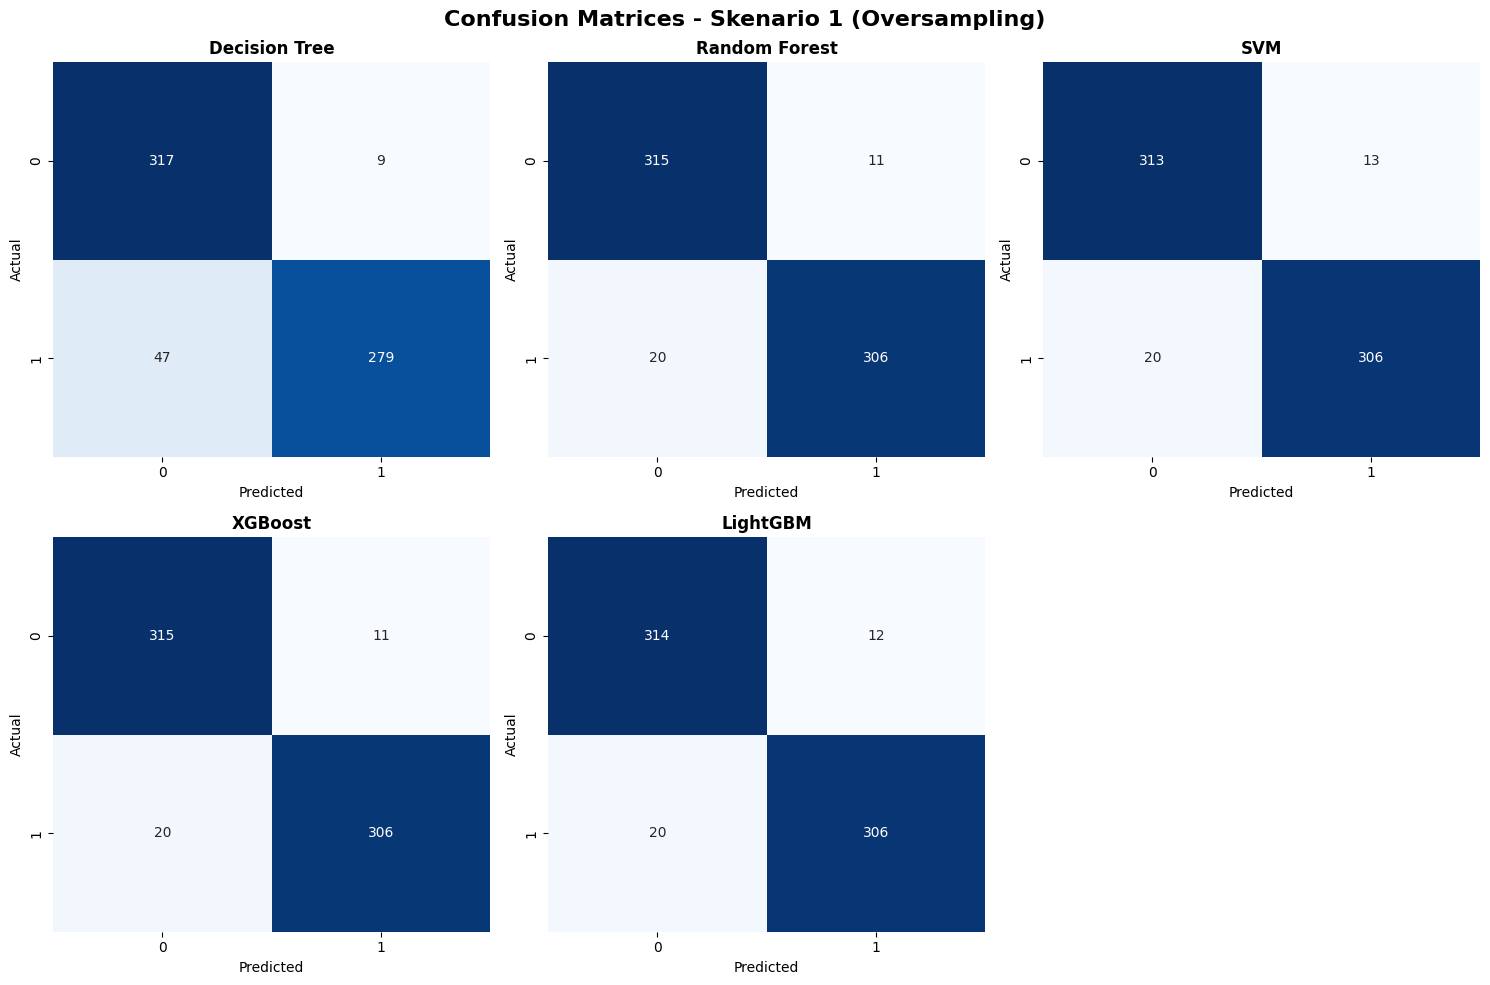

In [ ]:
# CONFUSION MATRIX - SKENARIO 1
print("📈 CONFUSION MATRICES - SKENARIO 1 (OVERSAMPLING)")

n_models = len(models_over)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(models_over.items()):
    if idx < 6:
        y_pred = model.predict(X_test_over)
        cm = confusion_matrix(y_test_over, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{model_name}', fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

# Hide unused subplots
for idx in range(n_models, 6):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices - Skenario 1 (Oversampling)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

ROC Curve Skenario 1

📈 ROC CURVES - SKENARIO 1 (OVERSAMPLING)


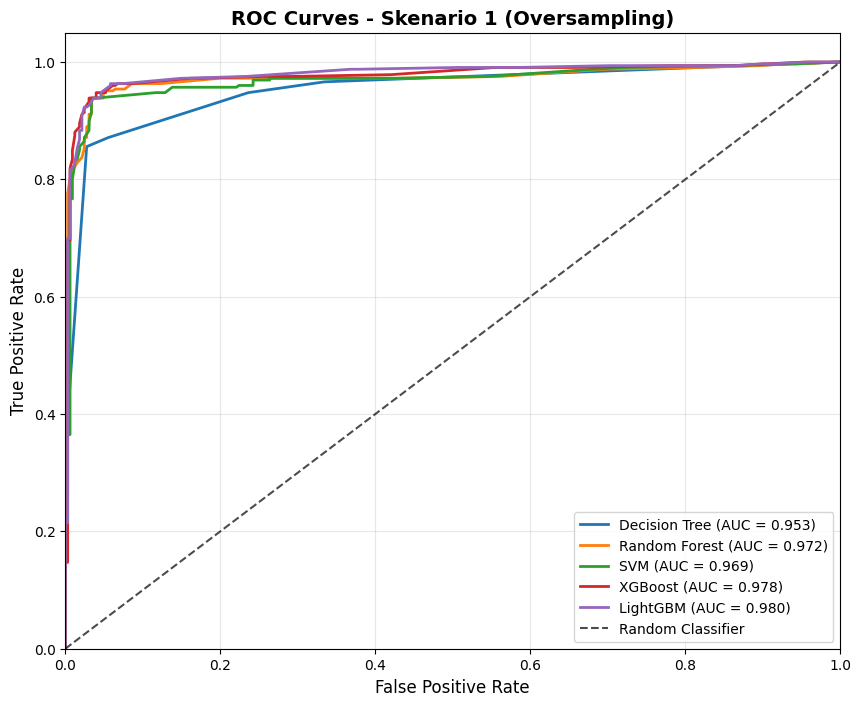

In [ ]:
# ROC CURVES - SKENARIO 1
print("📈 ROC CURVES - SKENARIO 1 (OVERSAMPLING)")

plt.figure(figsize=(10, 8))

for model_name, data in roc_data_scenario1.items():
    if 'fpr' in data:  # Binary
        plt.plot(data['fpr'], data['tpr'],
                label=f'{model_name} (AUC = {data["auc"]:.3f})',
                linewidth=2)
    else:  # Multiclass
        if 'auc' in data and data['auc'] is not None:
            plt.plot([], [], label=f'{model_name} (AUC = {data["auc"]:.3f})', linewidth=2)

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Skenario 1 (Oversampling)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

 # SKENARIO 2

**SELEKSI FITUR (CHI-SQUARE)**


==== Analisis Chi-square Manual per Fitur ====
Melakukan analisis Chi-square untuk setiap fitur...

ANALISIS FITUR: A

Tabel Kontingensi antara A dan Target:
N       0    1   All
A                   
1     535  250   785
2     392  174   566
3     326  125   451
4     216   78   294
5     160   52   212
All  1629  679  2308

Uji Chi-Square untuk A:
• Nilai Chi-Square: 6.9592
• P-Value: 1.38e-01
• Derajat Kebebasan: 4
• Kesimpulan: TIDAK SIGNIFIKAN
• Interpretasi: Tidak ada hubungan yang signifikan antara A dan target (p >= 0.05)

Tabel Frekuensi yang Diharapkan (Expected Frequencies):
N       0       1
A                
1  554.06  230.94
2  399.49  166.51
3  318.32  132.68
4  207.51   86.49
5  149.63   62.37

Kontribusi setiap sel terhadap Chi-square:
N       0       1
A                
1  0.6555  1.5727
2  0.1403  0.3366
3  0.1854  0.4447
4  0.3476  0.8340
5  0.7186  1.7239

ANALISIS FITUR: UMUR_TAHUN

Tabel Kontingensi antara UMUR_TAHUN dan Target:
N              0    1   All
UMUR_T

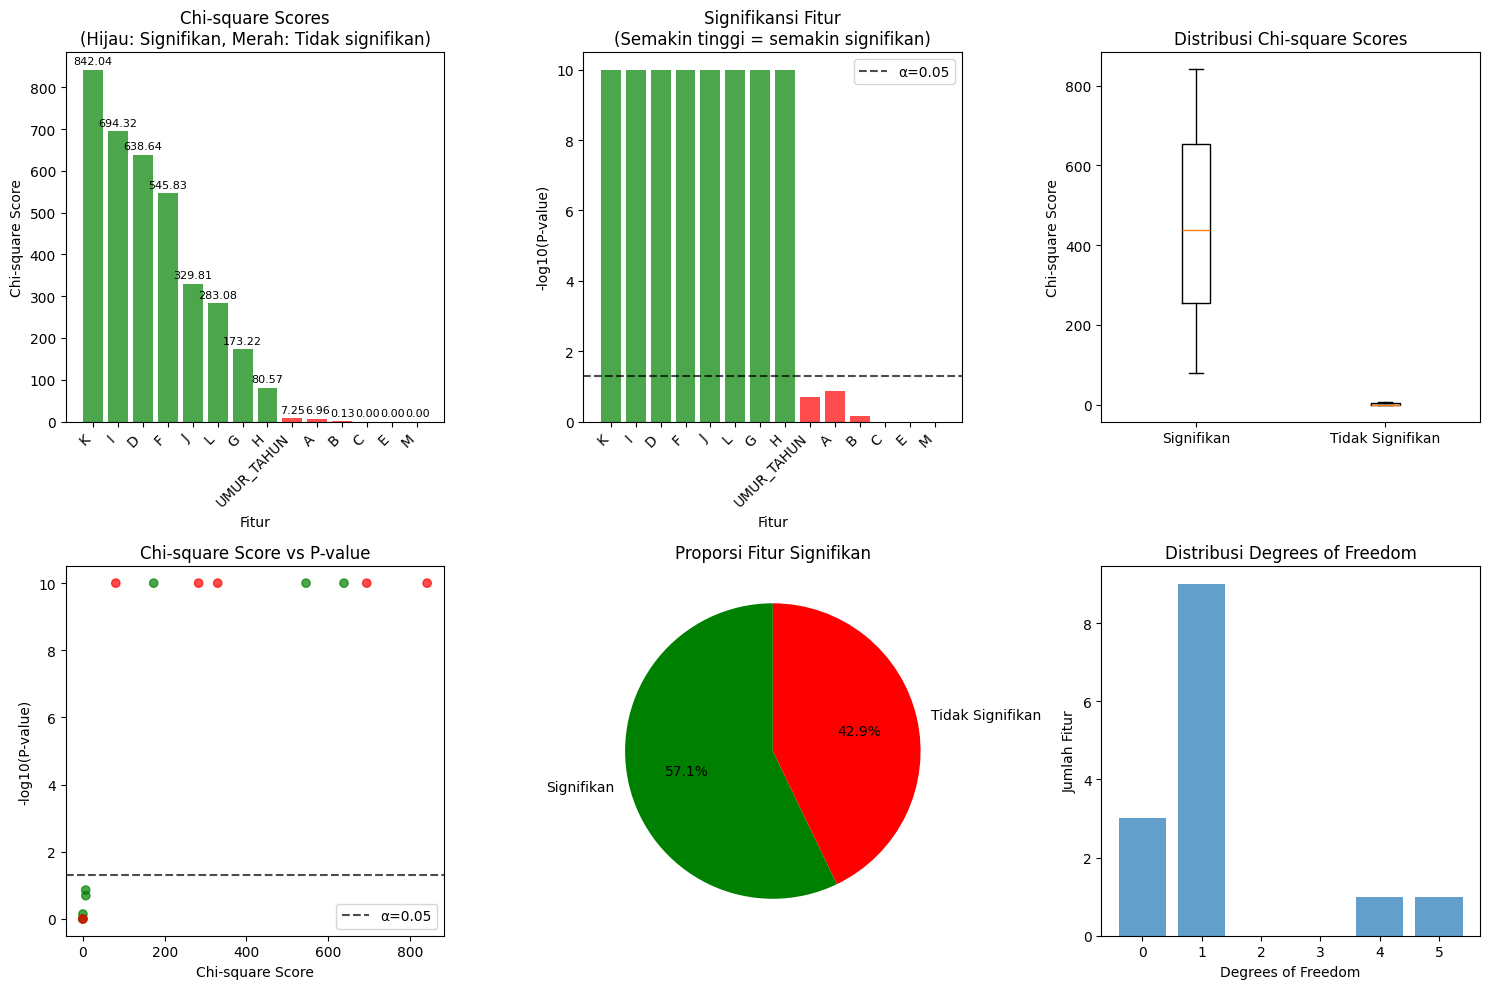


==== DATASET FINAL ====
Menggunakan metode seleksi: signifikansi statistik
Fitur terpilih: ['D', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

Dataset final untuk modeling:
- Shape X_final_selected: (2308, 8)
- Shape y_final: (2308,)

Contoh data hasil seleksi fitur:
   D  F  G  H  I  J  K  L
0  0  0  0  0  1  0  0  0
1  0  0  0  0  1  1  1  0
2  0  0  1  0  0  0  0  0
3  0  0  0  0  0  1  0  0
4  0  0  1  0  0  0  1  0

Statistik fitur terpilih:
                 D            F            G            H            I  \
count  2308.000000  2308.000000  2308.000000  2308.000000  2308.000000   
mean      0.146014     0.108319     0.084489     0.075823     0.376950   
std       0.353197     0.310850     0.278180     0.264772     0.484727   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.00

In [ ]:
# ==== ANALISIS CHI-SQUARE MANUAL ====
print("\n==== Analisis Chi-square Manual per Fitur ====")

def detailed_chi_square_analysis(X, y, alpha=0.05):
    """
    Analisis Chi-square detail dengan tabel kontingensi untuk setiap fitur
    """

    detailed_results = []

    for feature in X.columns:
        print(f"\n{'='*60}")
        print(f"ANALISIS FITUR: {feature}")
        print('='*60)

        # Buat tabel kontingensi
        contingency_table = pd.crosstab(X[feature], y, margins=True)
        print(f"\nTabel Kontingensi antara {feature} dan Target:")
        print(contingency_table)

        # Hitung Chi-square test
        # Hapus baris dan kolom 'All' untuk perhitungan
        ct_for_test = contingency_table.iloc[:-1, :-1]

        if ct_for_test.shape[0] > 1 and ct_for_test.shape[1] > 1:
            chi2_stat, p_value, dof, expected = chi2_contingency(ct_for_test)

            print(f"\nUji Chi-Square untuk {feature}:")
            print(f"• Nilai Chi-Square: {chi2_stat:.4f}")
            print(f"• P-Value: {p_value:.2e}")
            print(f"• Derajat Kebebasan: {dof}")

            # Interpretasi
            if p_value < alpha:
                significance = "SIGNIFIKAN"
                interpretation = f"Ada hubungan yang signifikan antara {feature} dan target (p < {alpha})"
            else:
                significance = "TIDAK SIGNIFIKAN"
                interpretation = f"Tidak ada hubungan yang signifikan antara {feature} dan target (p >= {alpha})"

            print(f"• Kesimpulan: {significance}")
            print(f"• Interpretasi: {interpretation}")

            # Tabel Expected Frequencies
            print(f"\nTabel Frekuensi yang Diharapkan (Expected Frequencies):")
            expected_df = pd.DataFrame(expected,
                                     index=ct_for_test.index,
                                     columns=ct_for_test.columns)
            print(expected_df.round(2))

            # Hitung kontribusi setiap sel terhadap Chi-square
            contributions = ((ct_for_test - expected_df) ** 2) / expected_df
            print(f"\nKontribusi setiap sel terhadap Chi-square:")
            print(contributions.round(4))

            # Simpan hasil
            detailed_results.append({
                'Feature': feature,
                'Chi2_Statistic': chi2_stat,
                'P_Value': p_value,
                'Degrees_of_Freedom': dof,
                'Significance': significance,
                'Is_Significant': p_value < alpha,
                'Contingency_Shape': f"{ct_for_test.shape[0]}x{ct_for_test.shape[1]}"
            })

        else:
            print(f"\nPeringatan: Tabel kontingensi untuk {feature} tidak memiliki variasi yang cukup")
            print("Tidak dapat melakukan uji Chi-square")

            detailed_results.append({
                'Feature': feature,
                'Chi2_Statistic': 0,
                'P_Value': 1.0,
                'Degrees_of_Freedom': 0,
                'Significance': 'TIDAK VALID',
                'Is_Significant': False,
                'Contingency_Shape': f"{ct_for_test.shape[0]}x{ct_for_test.shape[1]}"
            })

    return pd.DataFrame(detailed_results)

def select_features_by_chi_square(chi_results, method='significant', k=None):
    """
    Seleksi fitur berdasarkan hasil Chi-square

    Parameters:
    - chi_results: DataFrame hasil dari detailed_chi_square_analysis
    - method: 'significant' (pilih yang signifikan) atau 'top_k' (pilih k terbaik)
    - k: jumlah fitur terbaik jika method='top_k'
    """

    if method == 'significant':
        # Pilih fitur yang signifikan
        selected_features = chi_results[chi_results['Is_Significant']]['Feature'].tolist()
        print(f"\nMemilih fitur berdasarkan signifikansi (p < 0.05):")

    elif method == 'top_k' and k is not None:
        # Pilih k fitur dengan Chi-square tertinggi
        selected_features = chi_results.nlargest(k, 'Chi2_Statistic')['Feature'].tolist()
        print(f"\nMemilih {k} fitur dengan Chi-square score tertinggi:")

    else:
        print("Method tidak valid. Gunakan 'significant' atau 'top_k' dengan parameter k")
        return []

    print(f"Fitur terpilih: {selected_features}")
    return selected_features

# Jalankan analisis Chi-square
print("Melakukan analisis Chi-square untuk setiap fitur...")
chi_results = detailed_chi_square_analysis(X_final, y_final)

# Tampilkan ringkasan hasil
print(f"\n{'='*80}")
print("RINGKASAN HASIL CHI-SQUARE")
print('='*80)

# Urutkan berdasarkan Chi-square statistic
chi_results_sorted = chi_results.sort_values('Chi2_Statistic', ascending=False)
print(chi_results_sorted.round(4))

# Statistik hasil
print(f"\n==== STATISTIK HASIL ====")
print(f"Total fitur dianalisis: {len(chi_results)}")
print(f"Fitur signifikan (p < 0.05): {chi_results['Is_Significant'].sum()}")
print(f"Fitur tidak signifikan: {(~chi_results['Is_Significant']).sum()}")

# Tampilkan fitur signifikan
significant_features = chi_results[chi_results['Is_Significant']]
if len(significant_features) > 0:
    print(f"\nFitur yang signifikan:")
    for _, row in significant_features.iterrows():
        print(f"• {row['Feature']}: Chi² = {row['Chi2_Statistic']:.4f}, p = {row['P_Value']:.2e}")
else:
    print("\nTidak ada fitur yang signifikan secara statistik (p < 0.05)")

# Pilihan seleksi fitur
print(f"\n==== OPSI SELEKSI FITUR ====")
print("1. Berdasarkan signifikansi statistik (p < 0.05)")
print("2. Berdasarkan k fitur terbaik (Chi-square tertinggi)")

# Contoh seleksi berdasarkan signifikansi
selected_features_significant = select_features_by_chi_square(chi_results, method='significant')

# Contoh seleksi berdasarkan top-k (misalnya 5 fitur terbaik)
k_best = min(5, len(chi_results))
selected_features_topk = select_features_by_chi_square(chi_results, method='top_k', k=k_best)

# Visualisasi hasil
print("\n==== Visualisasi Chi-square Results ====")
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Plot 1: Bar chart Chi-square scores
plt.subplot(2, 3, 1)
colors = ['green' if sig else 'red' for sig in chi_results_sorted['Is_Significant']]
bars = plt.bar(range(len(chi_results_sorted)), chi_results_sorted['Chi2_Statistic'],
               color=colors, alpha=0.7)
plt.xlabel('Fitur')
plt.ylabel('Chi-square Score')
plt.title('Chi-square Scores\n(Hijau: Signifikan, Merah: Tidak signifikan)')
plt.xticks(range(len(chi_results_sorted)), chi_results_sorted['Feature'], rotation=45, ha='right')

# Tambahkan nilai di atas bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(chi_results_sorted['Chi2_Statistic'])*0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# Plot 2: P-values
plt.subplot(2, 3, 2)
plt.bar(range(len(chi_results_sorted)), -np.log10(chi_results_sorted['P_Value'] + 1e-10),
        color=colors, alpha=0.7)
plt.xlabel('Fitur')
plt.ylabel('-log10(P-value)')
plt.title('Signifikansi Fitur\n(Semakin tinggi = semakin signifikan)')
plt.xticks(range(len(chi_results_sorted)), chi_results_sorted['Feature'], rotation=45, ha='right')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.7, label='α=0.05')
plt.legend()

# Plot 3: Distribusi Chi-square scores
plt.subplot(2, 3, 3)
significant_scores = chi_results[chi_results['Is_Significant']]['Chi2_Statistic']
not_significant_scores = chi_results[~chi_results['Is_Significant']]['Chi2_Statistic']

if len(significant_scores) > 0 and len(not_significant_scores) > 0:
    plt.boxplot([significant_scores, not_significant_scores],
                labels=['Signifikan', 'Tidak Signifikan'])
elif len(significant_scores) > 0:
    plt.boxplot([significant_scores], labels=['Signifikan'])
elif len(not_significant_scores) > 0:
    plt.boxplot([not_significant_scores], labels=['Tidak Signifikan'])

plt.ylabel('Chi-square Score')
plt.title('Distribusi Chi-square Scores')

# Plot 4: Scatter plot Chi-square vs P-value
plt.subplot(2, 3, 4)
plt.scatter(chi_results['Chi2_Statistic'], -np.log10(chi_results['P_Value'] + 1e-10),
           c=colors, alpha=0.7)
plt.xlabel('Chi-square Score')
plt.ylabel('-log10(P-value)')
plt.title('Chi-square Score vs P-value')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.7, label='α=0.05')
plt.legend()

# Plot 5: Pie chart signifikansi
plt.subplot(2, 3, 5)
sig_counts = chi_results['Is_Significant'].value_counts()
labels = ['Signifikan' if x else 'Tidak Signifikan' for x in sig_counts.index]
colors_pie = ['green', 'red']
plt.pie(sig_counts.values, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Fitur Signifikan')

# Plot 6: Heatmap degrees of freedom
plt.subplot(2, 3, 6)
dof_counts = chi_results['Degrees_of_Freedom'].value_counts().sort_index()
plt.bar(dof_counts.index, dof_counts.values, alpha=0.7)
plt.xlabel('Degrees of Freedom')
plt.ylabel('Jumlah Fitur')
plt.title('Distribusi Degrees of Freedom')

plt.tight_layout()
plt.show()

# Buat dataset final dengan fitur terpilih
print(f"\n==== DATASET FINAL ====")

# Pilih metode seleksi (bisa disesuaikan)
if len(selected_features_significant) > 0:
    final_selected_features = selected_features_significant
    selection_method = "signifikansi statistik"
else:
    final_selected_features = selected_features_topk
    selection_method = f"top-{k_best} Chi-square scores"

print(f"Menggunakan metode seleksi: {selection_method}")
print(f"Fitur terpilih: {final_selected_features}")

# Buat dataset final
X_final_selected = X_final[final_selected_features].copy()

print(f"\nDataset final untuk modeling:")
print(f"- Shape X_final_selected: {X_final_selected.shape}")
print(f"- Shape y_final: {y_final.shape}")

print(f"\nContoh data hasil seleksi fitur:")
print(X_final_selected.head())

print(f"\nStatistik fitur terpilih:")
print(X_final_selected.describe())

print("\n" + "="*80)
print("CHI-SQUARE FEATURE ANALYSIS SELESAI!")
print("="*80)
print("Dataset siap untuk tahap modeling dengan fitur yang telah dianalisis menggunakan Chi-square test.")

KLASIFIKASI DENGAN SELEKSI FITUR CHI-SQUARE


KLASIFIKASI - MODEL PADA DATA CHI-SQUARE (Split 80:20)

[1] PEMBAGIAN DATA DENGAN FITUR TERPILIH
Fitur terpilih (8):
1. D
2. F
3. G
4. H
5. I
6. J
7. K
8. L


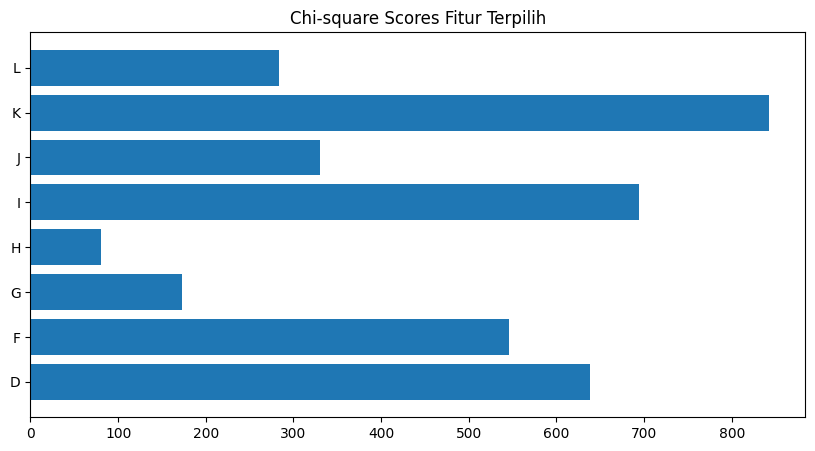


[2] PELATIHAN MODEL

=== Decision Tree ===

Feature Importance:
K    0.566084
D    0.203286
I    0.135235
J    0.095394
H    0.000000
G    0.000000
F    0.000000
L    0.000000
dtype: float64

Waktu training: 0.01 detik

=== Random Forest ===

Feature Importance:
K    0.264628
I    0.260186
D    0.151156
F    0.141568
J    0.099869
L    0.041753
G    0.031435
H    0.009405
dtype: float64

Waktu training: 0.25 detik

=== SVM ===

Waktu training: 0.16 detik

=== XGBoost ===

Feature Importance:
K    0.368116
D    0.263580
J    0.135482
I    0.096329
G    0.060841
L    0.038056
F    0.028084
H    0.009514
dtype: float32

Waktu training: 0.05 detik

=== LightGBM ===

Feature Importance:
K    457
I    450
F    342
J    331
H    312
G    250
L    223
D    219
dtype: int32

Waktu training: 0.05 detik


In [ ]:
# ============================================================
# SKENARIO 2: KLASIFIKASI DENGAN SELEKSI FITUR CHI-SQUARE
# ============================================================
print("\n" + "="*80)
print("KLASIFIKASI - MODEL PADA DATA CHI-SQUARE (Split 80:20)")
print("="*80)

# 1. Pembagian Data dengan Fitur Terpilih
print("\n[1] PEMBAGIAN DATA DENGAN FITUR TERPILIH")
X_train_chi = X_train_over[selected_features]
X_test_chi = X_test_over[selected_features]

print(f"Fitur terpilih ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"{i}. {feat}")

# Visualisasi fitur terpilih berdasarkan Chi-square scores
plt.figure(figsize=(10, 5))
# Use chi_results['Chi2_Score'] for plotting
plt.barh(range(len(selected_features)), chi_results.loc[chi_results['Feature'].isin(selected_features), 'Chi2_Statistic'])
plt.yticks(range(len(selected_features)), selected_features)
plt.title('Chi-square Scores Fitur Terpilih')
plt.show()


# 2. Pelatihan Model
print("\n[2] PELATIHAN MODEL")
from sklearn.base import clone
import time
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'models' dictionary is already defined in a previous cell
trained_models_chi = {}

for name, model in models.items():
    print(f"\n=== {name} ===")

    # Clone model untuk memastikan fresh start
    model_copy = clone(model)

    # Training
    start_time = time.time()
    model_copy.fit(X_train_chi, y_train_over)
    train_time = time.time() - start_time

    # Store the trained model
    trained_models_chi[name] = model_copy

    # Feature importance (if available)
    if hasattr(model_copy, 'feature_importances_'):
        print("\nFeature Importance:")
        feat_imp = pd.Series(
            model_copy.feature_importances_,
            index=selected_features
        ).sort_values(ascending=False)
        print(feat_imp)
        # Optional: Plot feature importance
        # plt.figure(figsize=(10, 5))
        # feat_imp.plot(kind='barh')
        # plt.title(f'Feature Importance - {name}')
        # plt.show()


    print(f"\nWaktu training: {train_time:.2f} detik")

Penyesuaian Variabel

In [ ]:
# =====================================================================================
# PENYESUAIAN NAMA VARIABEL UNTUK EVALUASI SKENARIO 2
# =====================================================================================

models_over = trained_models_over
models_chi = trained_models_chi

print("✅ Variabel evaluasi sudah siap!")
print(f"Skenario 1 - Model tersedia: {list(models_over.keys())}")
print(f"Skenario 2 - Model tersedia: {list(models_chi.keys())}")

# Cek data yang tersedia
print(f"\n📊 DATA SKENARIO 2:")
print(f"• X_train_chi shape: {X_train_chi.shape}")
print(f"• X_test_chi shape: {X_test_chi.shape}")
print(f"• Fitur terpilih: {len(selected_features)} dari {len(X_final.columns)} fitur")
print(f"• Reduksi fitur: {((len(X_final.columns) - len(selected_features))/len(X_final.columns)*100):.1f}%")
print(f"• Fitur: {selected_features}")

✅ Variabel evaluasi sudah siap!
Skenario 1 - Model tersedia: ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM']
Skenario 2 - Model tersedia: ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM']

📊 DATA SKENARIO 2:
• X_train_chi shape: (2606, 8)
• X_test_chi shape: (652, 8)
• Fitur terpilih: 8 dari 14 fitur
• Reduksi fitur: 42.9%
• Fitur: ['D', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


EVALUASI SKENARIO 2 - METRIK

In [ ]:
# =====================================================================================
# EVALUASI SKENARIO 2: SELEKSI FITUR - CHI-SQUARE
# =====================================================================================
print("="*100)
print("SKENARIO 2: SELEKSI FITUR - CHI-SQUARE")
print("="*100)

print("\n📋 DESKRIPSI SKENARIO 2:")
print("• Metode: Chi-Square untuk seleksi fitur")
print("• Tujuan: Memilih fitur yang paling relevan untuk klasifikasi")
print("• Model yang diuji: Decision Tree, Random Forest, SVM, XGBoost, LightGBM")
print(f"• Fitur terpilih: {len(selected_features)} dari {len(X_final.columns)} fitur")

# Evaluasi model chi-square
results_scenario2, roc_data_scenario2 = comprehensive_evaluation(
    models_chi, X_train_chi, X_test_chi, y_train_over, y_test_over, "Chi-Square"
)

# Tampilkan tabel hasil Skenario 2
print("\n📊 TABEL HASIL EVALUASI - SKENARIO 2 (CHI-SQUARE):")
print(results_scenario2.round(4))

SKENARIO 2: SELEKSI FITUR - CHI-SQUARE

📋 DESKRIPSI SKENARIO 2:
• Metode: Chi-Square untuk seleksi fitur
• Tujuan: Memilih fitur yang paling relevan untuk klasifikasi
• Model yang diuji: Decision Tree, Random Forest, SVM, XGBoost, LightGBM
• Fitur terpilih: 8 dari 14 fitur

EVALUASI LENGKAP - CHI-SQUARE
Tipe Klasifikasi: Binary
Jumlah Kelas: 2
Kelas: [np.int64(0), np.int64(1)]

EVALUASI MODEL: Decision Tree

METRIK DASAR:
• Accuracy  : 0.9141 (91.41%)
• Precision : 0.9198 (91.98%)
• Recall    : 0.9141 (91.41%)
• F1-Score  : 0.9138 (91.38%)
• AUC-ROC   : 0.9532

EVALUASI MODEL: Random Forest

METRIK DASAR:
• Accuracy  : 0.9525 (95.25%)
• Precision : 0.9528 (95.28%)
• Recall    : 0.9525 (95.25%)
• F1-Score  : 0.9524 (95.24%)
• AUC-ROC   : 0.9705

EVALUASI MODEL: SVM

METRIK DASAR:
• Accuracy  : 0.9494 (94.94%)
• Precision : 0.9496 (94.96%)
• Recall    : 0.9494 (94.94%)
• F1-Score  : 0.9494 (94.94%)
• AUC-ROC   : 0.9673

EVALUASI MODEL: XGBoost

METRIK DASAR:
• Accuracy  : 0.9479 (94.79%)

CONFUSION MATRIX SKENARIO 2

📈 CONFUSION MATRICES - SKENARIO 2 (CHI-SQUARE)


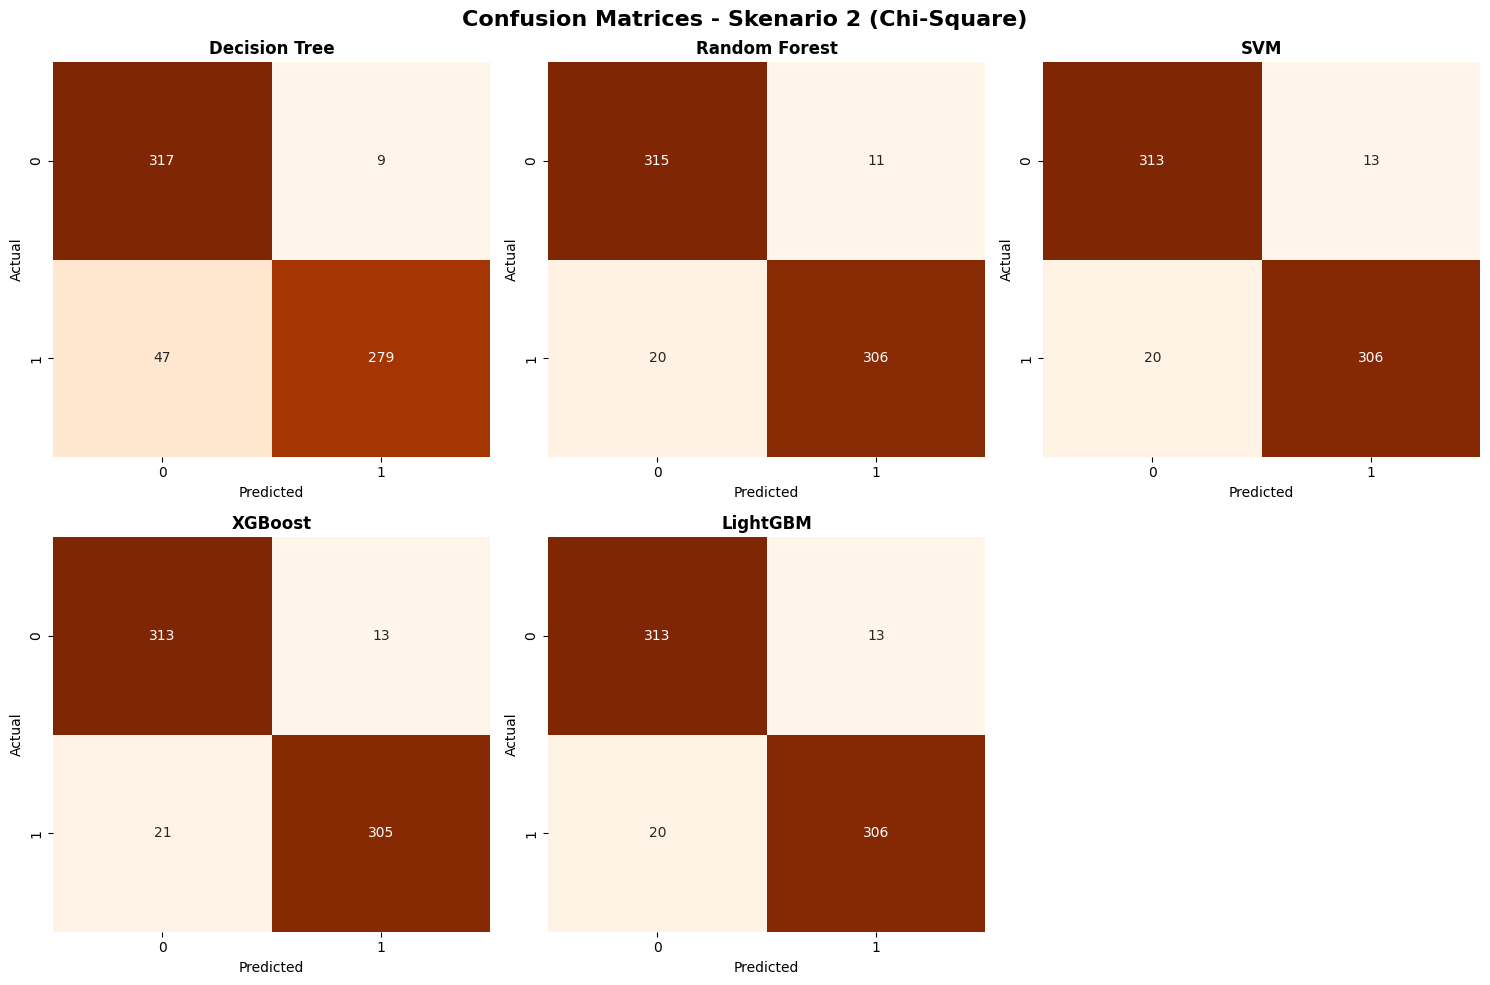

In [ ]:
# =====================================================================================
# CONFUSION MATRIX - SKENARIO 2 (CHI-SQUARE)
# =====================================================================================
print("📈 CONFUSION MATRICES - SKENARIO 2 (CHI-SQUARE)")

n_models = len(models_chi)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(models_chi.items()):
    if idx < 6:
        y_pred = model.predict(X_test_chi)
        cm = confusion_matrix(y_test_over, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                   cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{model_name}', fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

# Hide unused subplots
for idx in range(n_models, 6):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices - Skenario 2 (Chi-Square)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

ROC CURVE SKENARIO 2

📈 ROC CURVES - SKENARIO 2 (CHI-SQUARE)


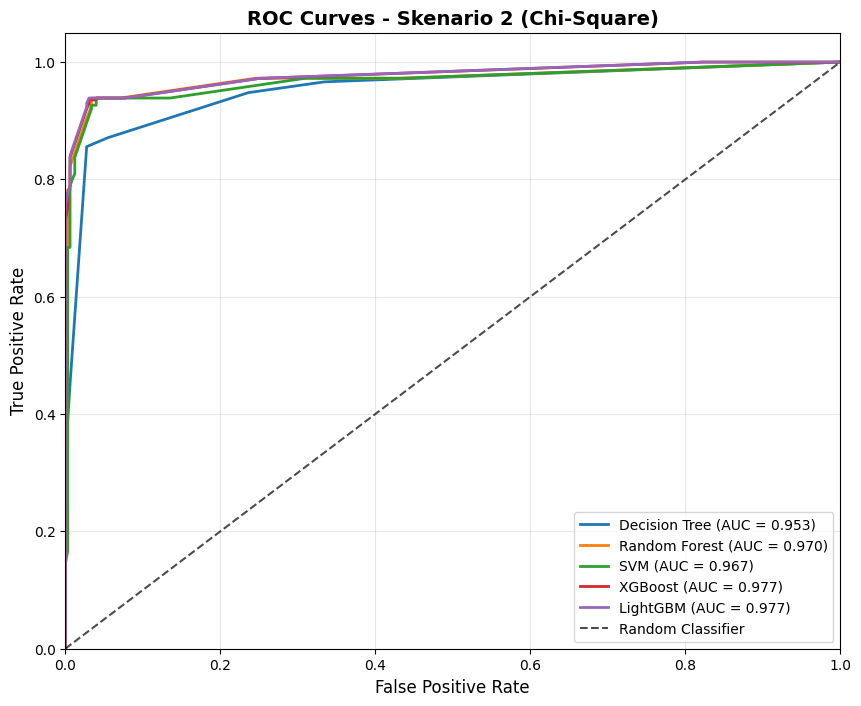

In [ ]:
# =====================================================================================
# ROC CURVES - SKENARIO 2 (CHI-SQUARE)
# =====================================================================================
print("📈 ROC CURVES - SKENARIO 2 (CHI-SQUARE)")

plt.figure(figsize=(10, 8))

# Check if multiclass
first_model_data = next(iter(roc_data_scenario2.values()))
is_multiclass = 'n_classes' in first_model_data and first_model_data['n_classes'] > 2

if is_multiclass:
    print("• Tipe: Multiclass ROC Curves (Weighted-average)")

for model_name, data in roc_data_scenario2.items():
    if 'fpr' in data:  # Binary
        plt.plot(data['fpr'], data['tpr'],
                label=f'{model_name} (AUC = {data["auc"]:.3f})',
                linewidth=2)
    else:  # Multiclass
        if 'auc' in data and data['auc'] is not None:
            plt.plot([], [], label=f'{model_name} (AUC = {data["auc"]:.3f})', linewidth=2)

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Skenario 2 (Chi-Square)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# PERBANDINGAN METRIK KEDUA SKENARIO

In [ ]:
# =====================================================================================
# PERBANDINGAN HASIL KEDUA SKENARIO
# =====================================================================================
print("="*100)
print("PERBANDINGAN HASIL EVALUASI KEDUA SKENARIO")
print("="*100)

print("\n📋 ANALISIS PERBANDINGAN:")
print("• Membandingkan performa model antara Skenario 1 (Oversampling) dan Skenario 2 (Chi-Square)")
print("• Menentukan skenario dan model terbaik berdasarkan metrik evaluasi")

# Gabungkan hasil
all_eval_results = pd.concat([results_scenario1, results_scenario2], ignore_index=True)

# Tabel perbandingan
print("\n📊 TABEL PERBANDINGAN METRIK KEDUA SKENARIO:")
comparison_table = all_eval_results.pivot_table(
    index='Model',
    columns='Scenario',
    values=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
)
print(comparison_table.round(4))

PERBANDINGAN HASIL EVALUASI KEDUA SKENARIO

📋 ANALISIS PERBANDINGAN:
• Membandingkan performa model antara Skenario 1 (Oversampling) dan Skenario 2 (Chi-Square)
• Menentukan skenario dan model terbaik berdasarkan metrik evaluasi

📊 TABEL PERBANDINGAN METRIK KEDUA SKENARIO:
                 AUC-ROC                Accuracy                F1-Score  \
Scenario      Chi-Square Oversampling Chi-Square Oversampling Chi-Square   
Model                                                                      
Decision Tree     0.9532       0.9532     0.9141       0.9141     0.9138   
LightGBM          0.9774       0.9800     0.9494       0.9509     0.9494   
Random Forest     0.9705       0.9718     0.9525       0.9525     0.9524   
SVM               0.9673       0.9687     0.9494       0.9494     0.9494   
XGBoost           0.9771       0.9778     0.9479       0.9525     0.9478   

                            Precision                  Recall               
Scenario      Oversampling Chi-Square Ov

VISUALISASI PERBANDINGAN

📈 VISUALISASI PERBANDINGAN METRIK


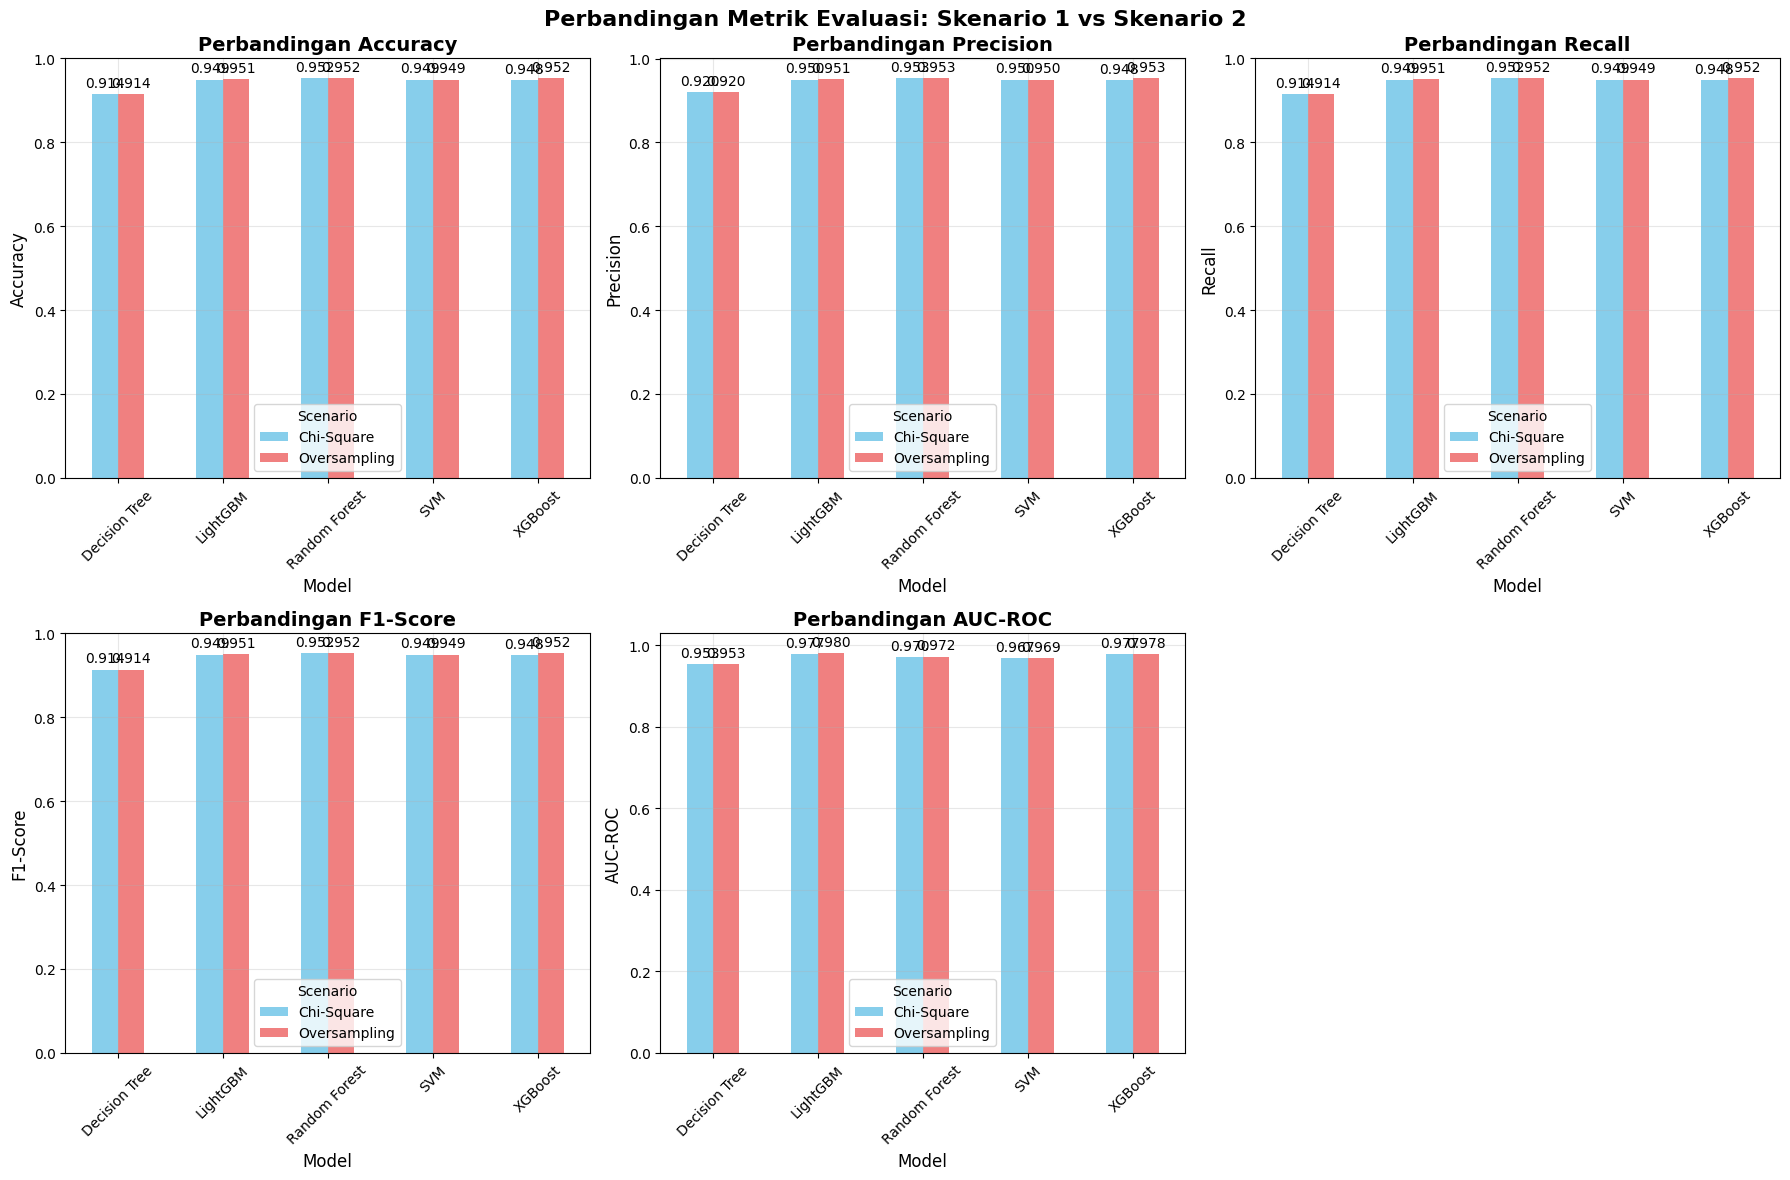

In [ ]:
# =====================================================================================
# VISUALISASI PERBANDINGAN METRIK
# =====================================================================================
print("📈 VISUALISASI PERBANDINGAN METRIK")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3

    # Prepare data
    plot_data = all_eval_results.pivot(index='Model', columns='Scenario', values=metric)

    # Create grouped bar plot
    plot_data.plot(kind='bar', ax=axes[row, col], color=['skyblue', 'lightcoral'])
    axes[row, col].set_title(f'Perbandingan {metric}', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('Model', fontsize=12)
    axes[row, col].set_ylabel(metric, fontsize=12)
    axes[row, col].legend(title='Scenario')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

    # Add value labels
    for container in axes[row, col].containers:
        axes[row, col].bar_label(container, fmt='%.3f', padding=3)

# Hide unused subplot
axes[1, 2].axis('off')

plt.suptitle('Perbandingan Metrik Evaluasi: Skenario 1 vs Skenario 2',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

ANALISIS DAN REKOMENDASI

In [ ]:
# =====================================================================================
# ANALISIS DAN REKOMENDASI FINAL
# =====================================================================================
print("="*100)
print("ANALISIS DAN REKOMENDASI FINAL")
print("="*100)

# Model terbaik per skenario
print("\n📌 MODEL TERBAIK PER SKENARIO:")

# Skenario 1 - Oversampling
best_scenario1_idx = results_scenario1['F1-Score'].idxmax()
best_scenario1_model = results_scenario1.loc[best_scenario1_idx]
print(f"\n🔵 SKENARIO 1 (OVERSAMPLING):")
print(f"   • Model Terbaik: {best_scenario1_model['Model']}")
print(f"   • Accuracy: {best_scenario1_model['Accuracy']:.4f} ({best_scenario1_model['Accuracy']*100:.2f}%)")
print(f"   • Precision: {best_scenario1_model['Precision']:.4f}")
print(f"   • Recall: {best_scenario1_model['Recall']:.4f}")
print(f"   • F1-Score: {best_scenario1_model['F1-Score']:.4f}")
print(f"   • AUC-ROC: {best_scenario1_model['AUC-ROC']:.4f}")

# Skenario 2 - Chi-Square
best_scenario2_idx = results_scenario2['F1-Score'].idxmax()
best_scenario2_model = results_scenario2.loc[best_scenario2_idx]
print(f"\n🟠 SKENARIO 2 (CHI-SQUARE):")
print(f"   • Model Terbaik: {best_scenario2_model['Model']}")
print(f"   • Accuracy: {best_scenario2_model['Accuracy']:.4f} ({best_scenario2_model['Accuracy']*100:.2f}%)")
print(f"   • Precision: {best_scenario2_model['Precision']:.4f}")
print(f"   • Recall: {best_scenario2_model['Recall']:.4f}")
print(f"   • F1-Score: {best_scenario2_model['F1-Score']:.4f}")
print(f"   • AUC-ROC: {best_scenario2_model['AUC-ROC']:.4f}")

# Model terbaik overall
print("\n🏆 MODEL TERBAIK SECARA KESELURUHAN:")
best_overall_idx = all_eval_results['F1-Score'].idxmax()
best_overall = all_eval_results.loc[best_overall_idx]
print(f"   • Model: {best_overall['Model']}")
print(f"   • Skenario: {best_overall['Scenario']}")
print(f"   • Accuracy: {best_overall['Accuracy']:.4f} ({best_overall['Accuracy']*100:.2f}%)")
print(f"   • Precision: {best_overall['Precision']:.4f}")
print(f"   • Recall: {best_overall['Recall']:.4f}")
print(f"   • F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   • AUC-ROC: {best_overall['AUC-ROC']:.4f}")

# Perbandingan rata-rata skenario
print("\n📊 PERBANDINGAN RATA-RATA PERFORMA SKENARIO:")
avg_metrics_scenario = all_eval_results.groupby('Scenario')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].mean()
print(avg_metrics_scenario.round(4))

# Insight feature selection
print("\n🔍 INSIGHT FEATURE SELECTION:")
print(f"• Jumlah fitur asli: {len(X_final.columns)}")
print(f"• Jumlah fitur terpilih: {len(selected_features)}")
print(f"• Reduksi fitur: {((len(X_final.columns) - len(selected_features))/len(X_final.columns)*100):.1f}%")

# Kesimpulan
scenario1_avg_f1 = avg_metrics_scenario.loc['Oversampling', 'F1-Score']
scenario2_avg_f1 = avg_metrics_scenario.loc['Chi-Square', 'F1-Score']
performance_diff = abs(scenario1_avg_f1 - scenario2_avg_f1)

print("\n💡 KESIMPULAN DAN REKOMENDASI:")
if scenario1_avg_f1 > scenario2_avg_f1:
    winning_scenario = "OVERSAMPLING (Skenario 1)"
    print(f"🔵 SKENARIO 1 (OVERSAMPLING) memberikan performa lebih baik")
    print(f"   • Rata-rata F1-Score: {scenario1_avg_f1:.4f} vs {scenario2_avg_f1:.4f}")
    print(f"   • Kesimpulan: Mengatasi imbalanced data lebih penting daripada seleksi fitur")
else:
    winning_scenario = "CHI-SQUARE (Skenario 2)"
    print(f"🟠 SKENARIO 2 (CHI-SQUARE) memberikan performa lebih baik")
    print(f"   • Rata-rata F1-Score: {scenario2_avg_f1:.4f} vs {scenario1_avg_f1:.4f}")
    print(f"   • Kesimpulan: Seleksi fitur berhasil meningkatkan performa model")

print(f"\n✅ REKOMENDASI FINAL:")
print(f"   Model {best_overall['Model']} dengan pendekatan {best_overall['Scenario']} direkomendasikan!")
print(f"   F1-Score: {best_overall['F1-Score']:.4f} | AUC-ROC: {best_overall['AUC-ROC']:.4f}")

ANALISIS DAN REKOMENDASI FINAL

📌 MODEL TERBAIK PER SKENARIO:

🔵 SKENARIO 1 (OVERSAMPLING):
   • Model Terbaik: Random Forest
   • Accuracy: 0.9525 (95.25%)
   • Precision: 0.9528
   • Recall: 0.9525
   • F1-Score: 0.9524
   • AUC-ROC: 0.9718

🟠 SKENARIO 2 (CHI-SQUARE):
   • Model Terbaik: Random Forest
   • Accuracy: 0.9525 (95.25%)
   • Precision: 0.9528
   • Recall: 0.9525
   • F1-Score: 0.9524
   • AUC-ROC: 0.9705

🏆 MODEL TERBAIK SECARA KESELURUHAN:
   • Model: Random Forest
   • Skenario: Oversampling
   • Accuracy: 0.9525 (95.25%)
   • Precision: 0.9528
   • Recall: 0.9525
   • F1-Score: 0.9524
   • AUC-ROC: 0.9718

📊 PERBANDINGAN RATA-RATA PERFORMA SKENARIO:
              Accuracy  Precision  Recall  F1-Score  AUC-ROC
Scenario                                                    
Chi-Square      0.9426     0.9440  0.9426    0.9426   0.9691
Oversampling    0.9439     0.9452  0.9439    0.9438   0.9703

🔍 INSIGHT FEATURE SELECTION:
• Jumlah fitur asli: 14
• Jumlah fitur terpilih: 8


 EXPORT HASIL

In [ ]:
# =====================================================================================
# EXPORT HASIL EVALUASI
# =====================================================================================
print("="*100)
print("EXPORT HASIL EVALUASI")
print("="*100)

# Simpan hasil lengkap
output_filename = "hasil_evaluasi_klasifikasi_kelompok_dea.csv"
all_eval_results.to_csv(output_filename, index=False)
print(f"✅ Hasil evaluasi lengkap: {output_filename}")

# Simpan ringkasan
summary_results = {
    'Skenario_1_Terbaik': f"{best_scenario1_model['Model']} (F1: {best_scenario1_model['F1-Score']:.4f})",
    'Skenario_2_Terbaik': f"{best_scenario2_model['Model']} (F1: {best_scenario2_model['F1-Score']:.4f})",
    'Model_Terbaik_Overall': f"{best_overall['Model']} - {best_overall['Scenario']} (F1: {best_overall['F1-Score']:.4f})",
    'Skenario_Terpilih': winning_scenario,
    'Jumlah_Fitur_Asli': len(X_final.columns),
    'Jumlah_Fitur_Terpilih': len(selected_features),
    'Reduksi_Fitur_Persen': f"{((len(X_final.columns) - len(selected_features))/len(X_final.columns)*100):.1f}%"
}

summary_df = pd.DataFrame([summary_results])
summary_df.to_csv("ringkasan_evaluasi_dea.csv", index=False)
print(f"✅ Ringkasan evaluasi: ringkasan_evaluasi_dea.csv")

# Simpan detail chi-square
chi_results.to_csv("detail_chi_square_analysis.csv", index=False)
print(f"✅ Detail chi-square analysis: detail_chi_square_analysis.csv")

# Preview hasil
print("\n📄 PREVIEW HASIL:")
print("Hasil Evaluasi Lengkap:")
print(all_eval_results.head())
print("\nRingkasan:")
print(summary_df)


EXPORT HASIL EVALUASI
✅ Hasil evaluasi lengkap: hasil_evaluasi_klasifikasi_kelompok_dea.csv
✅ Ringkasan evaluasi: ringkasan_evaluasi_dea.csv
✅ Detail chi-square analysis: detail_chi_square_analysis.csv

📄 PREVIEW HASIL:
Hasil Evaluasi Lengkap:
           Model      Scenario  Accuracy  Precision    Recall  F1-Score  \
0  Decision Tree  Oversampling  0.914110   0.919815  0.914110  0.913818   
1  Random Forest  Oversampling  0.952454   0.952799  0.952454  0.952445   
2            SVM  Oversampling  0.949387   0.949594  0.949387  0.949381   
3        XGBoost  Oversampling  0.952454   0.952799  0.952454  0.952445   
4       LightGBM  Oversampling  0.950920   0.951192  0.950920  0.950913   

    AUC-ROC  
0  0.953211  
1  0.971837  
2  0.968723  
3  0.977765  
4  0.979958  

Ringkasan:
           Skenario_1_Terbaik          Skenario_2_Terbaik  \
0  Random Forest (F1: 0.9524)  Random Forest (F1: 0.9524)   

                       Model_Terbaik_Overall          Skenario_Terpilih  \
0  Random F